# Try with 20 observations

In [1]:
import numpy as np
from numpy import zeros, eye, array, diag, exp, ones, tanh, cosh, dstack, log, hstack, vstack, sinh
from numpy.linalg import solve, norm
from numpy.random import choice, default_rng, randint, randn
from scipy.stats import multivariate_normal as MVN
from scipy.special import logsumexp
from scipy.stats import uniform as udist
import math
import time
from copy import deepcopy

import matplotlib.pyplot as plt
from matplotlib import rc
from ipywidgets.widgets import IntSlider
from ipywidgets.widgets import interact
from warnings import resetwarnings, catch_warnings, filterwarnings

from Manifolds.GKManifoldNew import GKManifold, data_generator, find_point_on_manifold, find_point_on_manifold_from_θ
from markov_snippets import MSAdaptive, SMCAdaptive
from tangential_hug_functions import TangentialHugSampler
from RWM import RWM

In [2]:
seed = 1234
m = 20     # number of latent variables
d = m + 4  # dimensionality of x-component

In [3]:
def generate_settings(
    d=d, 
    N=2000,
    B=20,
    δ=0.01,
    δmin=1e-3,
    δmax=100.0,
    εmin=1e-16,
    min_pm=1e-4,
    maxiter=500,
    verbose=False,
    εs_fixed=None,
    adaptiveε=True,
    adaptiveδ=False,
    z0_manual=None,
    pm_target=0.23,
    pm_switch=0.1,
    prior_seed=seed,
    low_memory=True,
    integrator='rwm',
    εprop_switch=0.01,
    ε0_manual=None,
    quantile_value=0.9,
    initialization='manual',
    switch_strategy='pm',
    kernel='uniform',
    prior_scale=7,
    thinning=10,
    burnin=100,
    use_autograd=False,
    stopping_criterion={'εmin', 'pm'},
    resampling_seed=1234,
    mh_kernel_seed=1234):
    # here d represents m+4
    # Generate the manifold
    θ0        = array([3.0, 1.0, 2.0, 0.5])       # True parameter value on U(0, 10) scale.
    ystar     = data_generator(θ0, m, seed=seed)  # Observed data
    q         = MVN(zeros(d), eye(d))             # Proposal distribution for THUG
    resetwarnings()
    manifold  = GKManifold(ystar, kernel_type=kernel, use_autograd=use_autograd)
    # grab arguments
    arguments = locals()
    return arguments

In [67]:
def generate_initial_particles(ϵ0, N=5000, s=0.001):
    # Generate Manifold
    θ0        = array([3.0, 1.0, 2.0, 0.5])       # True parameter value on U(0, 10) scale.
    ystar     = data_generator(θ0, m, seed=1234)  # Observed data
    resetwarnings()
    manifold  = GKManifold(ystar, kernel_type='uniform', use_autograd=False, θtrue=θ0)

    # Generate target distribution
    ξ0 = manifold.sample()               # Initial point on manifold                            # Starting epsilon
    logηε0 = manifold.generate_logηε(ε0)  # Target filamentary distribution

    # Sample from it using RWM
    s_rwm, a_rwm = RWM(x0=ξ0, s=s, N=N, logpi=logηε0)

    # Add velocities to particles
    v0_manual = randn(*s_rwm.shape)
    z0_manual = np.hstack((s_rwm, v0_manual))
    return z0_manual

def generate_initial_particles_on_manifold(N=5000, θtrue=False):
    # Generate Manifold
    θ0        = array([3.0, 1.0, 2.0, 0.5])       # True parameter value on U(0, 10) scale.
    ystar     = data_generator(θ0, m, seed=1234)  # Observed data
    resetwarnings()
    manifold  = GKManifold(ystar, kernel_type='uniform', use_autograd=False, θtrue=θ0)
    # Sample N times
    x0_manual = np.vstack([manifold.sample(fromtheta=θtrue) for _ in range(N)])
    v0_manual = randn(*x0_manual.shape)
    return np.hstack((x0_manual, v0_manual))

def generate_particles_on_manifold_then_rwm(ϵ0, N=5000, θtrue=False, δrwm=0.001):
    """First, generate particles on the manifold. Then use RWM to actually sample from a filamentary
    distribution of sorts."""
    # Generate manifold (used only to generate filamentary distribution)
    θ0        = array([3.0, 1.0, 2.0, 0.5])       # True parameter value on U(0, 10) scale.
    ystar     = data_generator(θ0, m, seed=1234)  # Observed data
    manifold  = GKManifold(ystar, kernel_type='uniform', use_autograd=False, θtrue=θ0)
    # Sample on manifold
    on_manifold = generate_initial_particles_on_manifold(N=N, θtrue=θtrue)
    x0_on_manifold = on_manifold[:, :on_manifold.shape[1]//2]
    # Store filamentary samples
    filamentary_samples = []
    for x0 in x0_on_manifold:
        filamentary_samples.append(RWM(x0, s=δrwm, N=1, logpi=manifold.generate_logηε(ϵ0))[0].flatten())
    # Create array
    v0_manual = randn(*x0_on_manifold.shape)
    x0_manual = np.vstack(filamentary_samples)
    return np.hstack((x0_manual, v0_manual))

def sample_from_filamentary(ε0, N=2000, n_per_sample=10, s=1.0):
    samples = []
    acceptances = []
    # Generate Manifold
    θ0        = array([3.0, 1.0, 2.0, 0.5])       # True parameter value on U(0, 10) scale.
    ystar     = data_generator(θ0, m, seed=1234)  # Observed data
    resetwarnings()
    manifold  = GKManifold(ystar, kernel_type='uniform', use_autograd=False, θtrue=θ0)
    # Construct filamentary distribution
    logηε0 = manifold.generate_logηε(ε0)
    while len(acceptances) < N:
        with catch_warnings():
            filterwarnings('error')
            try:
                # Sample on the manifold
                ξ0 = manifold.sample()
                # Sample starting from ξ0 and perform 10 steps of RWM. Grab the final point
                s_rwm, a_rwm = RWM(x0=ξ0, s=s, N=n_per_sample, logpi=logηε0)
                samples.append(s_rwm[-1])
                acceptances.append(np.mean(a_rwm)) #int(sum(a_rwm == 1) > 0))
            except RuntimeWarning:
                continue
    print("Acceptance Probability: {:.3f}".format(np.mean(acceptances)*100))
    x0_manual = vstack(samples)
    v0_manual = v0_manual = randn(*x0_manual.shape)
    return hstack((x0_manual, v0_manual))

In [5]:
ε0_manual = 20.0
init_particles = sample_from_filamentary(ε0_manual, s=0.3, n_per_sample=10)

Acceptance Probability: 75.700


# START FROM PRIOR

In [6]:
N      = 2000
B      = 20
δmin   = 1e-3
min_pm = 1e-4
pm_switch = 0.1
quantile_value = 0.5

### SMC-RWM $\delta=0.001$

In [27]:
SMC_RWM_0001_PRIOR = SMCAdaptive(generate_settings(
        d=d, 
        N=N,
        B=B,
        δ=0.001,
        δmin=δmin,
        min_pm=min_pm,
        verbose=True,
        εs_fixed=None,
        adaptiveε=True,
        adaptiveδ=False,
        z0_manual=None,
        pm_target=0.23,
        pm_switch=pm_switch,
        prior_seed=seed,
        low_memory=True,
        integrator='rwm',
        εprop_switch=0.01,
        ε0_manual=None,
        quantile_value=quantile_value,
        initialization='prior',
        switch_strategy='pm',
        kernel='uniform',
        use_autograd=False,
        stopping_criterion={'εmin', 'pm'},
        resampling_seed=1234,
        mh_kernel_seed=1234))
_ = SMC_RWM_0001_PRIOR.sample()

Stochastic Kernel: RWM.
Stopping criterion:  εmin, pm.
Setting initial epsilon to εmax = 6446696817851.2958984375000000
Iteration:  1
	Particles resampled.
	Epsilon: 16021.6268746205860225
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.4860000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  2
	Particles resampled.
	Epsilon: 522.3549807385128361
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.4610000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  3
	Particles resampled.
	Epsilon: 84.5446067776424997
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.4835000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  4
	Particles resampled.
	Epsilon: 44.4120582208767232
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.4725000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  5
	Particles resampled.
	Epsilon: 26.9112228679312153
	Weights computed and 

	Epsilon: 11.7936933622268931
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.3630000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  43
	Particles resampled.
	Epsilon: 11.5377685976793103
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.3470000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  44
	Particles resampled.
	Epsilon: 11.2546364980626574
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.3660000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  45
	Particles resampled.
	Epsilon: 10.9813757435425341
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.3585000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  46
	Particles resampled.
	Epsilon: 10.7059143559520820
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.3695000000000001
	Step-size kept fixed at: 0.0010000000000000
Iteration:  47
	Particles resampled.
	Epsilon: 

	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.2075000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  85
	Particles resampled.
	Epsilon: 4.8754472176285368
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.2095000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  86
	Particles resampled.
	Epsilon: 4.8151246172043800
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.2200000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  87
	Particles resampled.
	Epsilon: 4.7553369224777295
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.1960000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  88
	Particles resampled.
	Epsilon: 4.6964732090697661
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.2065000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  89
	Particles resampled.
	Epsilon: 4.6371323064108347
	Weights comput

	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.0735000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  127
	Particles resampled.
	Epsilon: 3.2485711786531510
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.0625000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  128
	Particles resampled.
	Epsilon: 3.2288407252829612
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.0685000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  129
	Particles resampled.
	Epsilon: 3.2060352229451832
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.0785000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  130
	Particles resampled.
	Epsilon: 3.1878184100785893
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.0725000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  131
	Particles resampled.
	Epsilon: 3.1686789819553196
	Weights c

	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.0445000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  169
	Particles resampled.
	Epsilon: 2.6595852556753430
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.0280000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  170
	Particles resampled.
	Epsilon: 2.6526182541523626
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.0200000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  171
	Particles resampled.
	Epsilon: 2.6451035394384097
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.0275000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  172
	Particles resampled.
	Epsilon: 2.6356242425202283
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.0150000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  173
	Particles resampled.
	Epsilon: 2.6293839564154133
	Weights c

	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.0145000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  211
	Particles resampled.
	Epsilon: 2.3517363753183469
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.0380000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  212
	Particles resampled.
	Epsilon: 2.3422760018391089
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.0350000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  213
	Particles resampled.
	Epsilon: 2.3301608739158048
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.0300000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  214
	Particles resampled.
	Epsilon: 2.3181907130773247
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.0400000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  215
	Particles resampled.
	Epsilon: 2.3071632761047542
	Weights c

	Epsilon: 1.3375962329432429
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.0450000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  253
	Particles resampled.
	Epsilon: 1.3125154939659147
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.0500000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  254
	Particles resampled.
	Epsilon: 1.2863961254703429
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.0525000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  255
	Particles resampled.
	Epsilon: 1.2560180264709460
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.0455000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  256
	Particles resampled.
	Epsilon: 1.2247454703017220
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.0465000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  257
	Particles resampled.
	Epsilon: 

### SMC-RT $\delta=0.1$

In [30]:
SMC_RT_0001_PRIOR = SMCAdaptive(generate_settings(
        d=d, 
        N=N,
        B=B,
        δ=0.01,
        δmin=δmin,
        min_pm=min_pm,
        verbose=True,
        εs_fixed=None,
        adaptiveε=True,
        adaptiveδ=False,
        z0_manual=None,
        pm_target=0.23,
        pm_switch=1e-3,
        prior_seed=seed,
        low_memory=True,
        integrator='rwm_then_thug',
        εprop_switch=0.01,
        ε0_manual=None,
        quantile_value=quantile_value,
        initialization='prior',
        switch_strategy='pm',
        kernel='uniform',
        use_autograd=False,
        stopping_criterion={'εmin', 'pm'},
        resampling_seed=1234,
        mh_kernel_seed=1234))
_ = SMC_RT_0001_PRIOR.sample()

Stochastic Kernel: RWM.
Stopping criterion:  εmin, pm.
Setting initial epsilon to εmax = 6446696817851.2958984375000000
Iteration:  1
	Particles resampled.
	Epsilon: 16021.6268746205860225
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.2910000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  2
	Particles resampled.
	Epsilon: 507.3768479511655300
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.2790000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  3
	Particles resampled.
	Epsilon: 79.1528831563204278
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.2635000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  4
	Particles resampled.
	Epsilon: 38.3960140131867576
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.2544999999999999
	Step-size kept fixed at: 0.0100000000000000
Iteration:  5
	Particles resampled.
	Epsilon: 25.1506120449503818
	Weights computed and 

### SMC-RT $\delta=0.001$

In [34]:
SMC_RT_0001_PRIOR = SMCAdaptive(generate_settings(
        d=d, 
        N=N,
        B=B,
        δ=0.001,
        δmin=δmin,
        min_pm=min_pm,
        verbose=True,
        εs_fixed=None,
        adaptiveε=True,
        adaptiveδ=False,
        z0_manual=None,
        pm_target=0.23,
        pm_switch=0.005,
        prior_seed=seed,
        low_memory=True,
        integrator='rwm_then_thug',
        εprop_switch=0.01,
        ε0_manual=None,
        quantile_value=quantile_value,
        initialization='prior',
        switch_strategy='pm',
        kernel='uniform',
        use_autograd=False,
        stopping_criterion={'εmin', 'pm'},
        resampling_seed=1234,
        mh_kernel_seed=1234))
_ = SMC_RT_0001_PRIOR.sample()

Stochastic Kernel: RWM.
Stopping criterion:  εmin, pm.
Setting initial epsilon to εmax = 6446696817851.2958984375000000
Iteration:  1
	Particles resampled.
	Epsilon: 16021.6268746205860225
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.4860000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  2
	Particles resampled.
	Epsilon: 522.3549807385128361
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.4610000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  3
	Particles resampled.
	Epsilon: 84.5446067776424997
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.4835000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  4
	Particles resampled.
	Epsilon: 44.4120582208767232
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.4725000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  5
	Particles resampled.
	Epsilon: 26.9112228679312153
	Weights computed and 

	Epsilon: 11.7936933622268931
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.3630000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  43
	Particles resampled.
	Epsilon: 11.5377685976793103
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.3470000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  44
	Particles resampled.
	Epsilon: 11.2546364980626574
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.3660000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  45
	Particles resampled.
	Epsilon: 10.9813757435425341
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.3585000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  46
	Particles resampled.
	Epsilon: 10.7059143559520820
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.3695000000000001
	Step-size kept fixed at: 0.0010000000000000
Iteration:  47
	Particles resampled.
	Epsilon: 

	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.2075000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  85
	Particles resampled.
	Epsilon: 4.8754472176285368
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.2095000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  86
	Particles resampled.
	Epsilon: 4.8151246172043800
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.2200000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  87
	Particles resampled.
	Epsilon: 4.7553369224777295
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.1960000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  88
	Particles resampled.
	Epsilon: 4.6964732090697661
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.2065000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  89
	Particles resampled.
	Epsilon: 4.6371323064108347
	Weights comput

	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.0735000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  127
	Particles resampled.
	Epsilon: 3.2485711786531510
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.0625000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  128
	Particles resampled.
	Epsilon: 3.2288407252829612
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.0685000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  129
	Particles resampled.
	Epsilon: 3.2060352229451832
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.0785000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  130
	Particles resampled.
	Epsilon: 3.1878184100785893
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.0725000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  131
	Particles resampled.
	Epsilon: 3.1686789819553196
	Weights c

	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.0445000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  169
	Particles resampled.
	Epsilon: 2.6595852556753430
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.0280000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  170
	Particles resampled.
	Epsilon: 2.6526182541523626
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.0200000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  171
	Particles resampled.
	Epsilon: 2.6451035394384097
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.0275000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  172
	Particles resampled.
	Epsilon: 2.6356242425202283
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.0150000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  173
	Particles resampled.
	Epsilon: 2.6293839564154133
	Weights c

	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.3085000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  210
	Particles resampled.
	Epsilon: 2.3965934394271651
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.2845000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  211
	Particles resampled.
	Epsilon: 2.3956291316523202
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.2615000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  212
	Particles resampled.
	Epsilon: 2.3945788913745436
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.2670000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  213
	Particles resampled.
	Epsilon: 2.3938851546839377
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.2320000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  214
	Particles resampled.
	Epsilon: 2.3931997054290397
	Weights c

	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.0004999999999999
	Step-size kept fixed at: 0.0010000000000000
Iteration:  252
	Particles resampled.
	Epsilon: 2.3877717191266106
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.0105000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  253
	Particles resampled.
	Epsilon: 2.3877635520183849
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.0054999999999999
	Step-size kept fixed at: 0.0010000000000000
Iteration:  254
	Particles resampled.
	Epsilon: 2.3877578063544949
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.0024999999999999
	Step-size kept fixed at: 0.0010000000000000
Iteration:  255
	Particles resampled.
	Epsilon: 2.3877545396092215
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.0004999999999999
	Step-size kept fixed at: 0.0010000000000000
Iteration:  256
	Particles resampled.
	Epsilon: 2.3877498058683235
	Weights c

In [46]:
SOMETHING = SMCAdaptive(generate_settings(
        d=d, 
        N=N,
        B=B,
        δ=0.001,
        δmin=δmin,
        min_pm=min_pm,
        verbose=True,
        εs_fixed=None,
        adaptiveε=True,
        adaptiveδ=False,
        z0_manual=None,
        pm_target=0.23,
        pm_switch=0.003,
        prior_seed=seed,
        low_memory=True,
        integrator='rwm_then_thug',
        εprop_switch=0.01,
        ε0_manual=None,
        quantile_value=0.2,
        initialization='prior',
        switch_strategy='pm',
        kernel='uniform',
        use_autograd=False,
        stopping_criterion={'εmin', 'pm'},
        resampling_seed=1234,
        mh_kernel_seed=1234))
_ = SOMETHING.sample()

Stochastic Kernel: RWM.
Stopping criterion:  εmin, pm.
Setting initial epsilon to εmax = 6446696817851.2958984375000000
Iteration:  1
	Particles resampled.
	Epsilon: 238.6262708911633581
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.1950000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  2
	Particles resampled.
	Epsilon: 30.9291900174242755
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.1915000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  3
	Particles resampled.
	Epsilon: 20.1467341610855009
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.1905000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  4
	Particles resampled.
	Epsilon: 18.0492630671341168
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.1810000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  5
	Particles resampled.
	Epsilon: 17.0321061010741666
	Weights computed and nor

	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.0629999999999999
	Step-size kept fixed at: 0.0010000000000000
Iteration:  43
	Particles resampled.
	Epsilon: 6.1077748920927828
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.0580000000000001
	Step-size kept fixed at: 0.0010000000000000
Iteration:  44
	Particles resampled.
	Epsilon: 5.9928119690227541
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.0570000000000001
	Step-size kept fixed at: 0.0010000000000000
Iteration:  45
	Particles resampled.
	Epsilon: 5.8328776761591028
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.0580000000000001
	Step-size kept fixed at: 0.0010000000000000
Iteration:  46
	Particles resampled.
	Epsilon: 5.6722121349979959
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.0575000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  47
	Particles resampled.
	Epsilon: 5.5324524472028767
	Weights comput

	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.0140000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  85
	Particles resampled.
	Epsilon: 3.1631305621817556
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.0260000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  86
	Particles resampled.
	Epsilon: 3.1302208297561167
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.0050000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  87
	Particles resampled.
	Epsilon: 3.0950076867541458
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.0054999999999999
	Step-size kept fixed at: 0.0010000000000000
Iteration:  88
	Particles resampled.
	Epsilon: 3.0700856424201488
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.0024999999999999
	Step-size kept fixed at: 0.0010000000000000


####################################
### SWITCHING TO THUG KERNEL ###
#########

	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.0945000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  126
	Particles resampled.
	Epsilon: 2.8538151333279789
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.0905000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  127
	Particles resampled.
	Epsilon: 2.8525194283083324
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.0940000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  128
	Particles resampled.
	Epsilon: 2.8515270907281529
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.0725000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  129
	Particles resampled.
	Epsilon: 2.8506716752820958
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.0625000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  130
	Particles resampled.
	Epsilon: 2.8499719858758645
	Weights c

### MS-RWM $\delta=0.001$

In [19]:
MS_RWM_0001_PRIOR = MSAdaptive(generate_settings(
        d=d, 
        N=N,
        B=B,
        δ=0.001,
        δmin=δmin,
        min_pm=min_pm,
        verbose=True,
        εs_fixed=None,
        adaptiveε=True,
        adaptiveδ=True,
        z0_manual=None,
        pm_target=0.23,
        pm_switch=pm_switch,
        prior_seed=seed,
        low_memory=True,
        integrator='rwm',
        εprop_switch=0.01,
        ε0_manual=None,
        quantile_value=quantile_value,
        initialization='prior',
        switch_strategy='pm',
        kernel='uniform',
        use_autograd=False,
        stopping_criterion={'εmin', 'pm'},
        resampling_seed=1234))
_ = MS_RWM_0001_PRIOR.sample()

Integrator: RWM.
Stopping criterion:  εmin, pm.
Setting initial epsilon to εmax = 6446696817851.2958984375000000
Iteration:  1
	Trajectories constructed.
	Epsilon: 16995.6902395905053709
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9395000000000000
	Step-size adapted to: 0.0014258241536823
Iteration:  2
	Trajectories constructed.
	Epsilon: 459.0954998099410318
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9570000000000000
	Step-size adapted to: 0.0020508410965418
Iteration:  3
	Trajectories constructed.
	Epsilon: 88.7467737837301627
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9535000000000000
	Step-size adapted to: 0.0029446795510655
Iteration:  4
	Trajectories constructed.
	Epsilon: 42.9039687438075745
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9580000000000000
	Step-size adapted to: 0.0042

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1845000000000000
	Step-size adapted to: 0.0834919316297935
Iteration:  38
	Trajectories constructed.
	Epsilon: 3.3252035922683998
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1195000000000000
	Step-size adapted to: 0.0790041197625221
Iteration:  39
	Trajectories constructed.
	Epsilon: 3.2333301719202314
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1290000000000000
	Step-size adapted to: 0.0751134772455170
Iteration:  40
	Trajectories constructed.
	Epsilon: 3.1479615886938550
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2225000000000000
	Step-size adapted to: 0.0748323291879245
Iteration:  41
	Trajectories constructed.
	Epsilon: 3.0418439345193922
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2050000000

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0725000000000000
	Step-size adapted to: 0.0167558927102548
Iteration:  75
	Trajectories constructed.
	Epsilon: 0.9867682556931173
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0490000000000000
	Step-size adapted to: 0.0153060779324158
Iteration:  76
	Trajectories constructed.
	Epsilon: 0.9782553435175319
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0340000000000000
	Step-size adapted to: 0.0138772387781969
Iteration:  77
	Trajectories constructed.
	Epsilon: 0.9707444636541718
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0265000000000000
	Step-size adapted to: 0.0125346899930989
Iteration:  78
	Trajectories constructed.
	Epsilon: 0.9626468761650386
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2535000000

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1515000000000000
	Step-size adapted to: 0.0042439735992117
Iteration:  112
	Trajectories constructed.
	Epsilon: 0.8101932571697513
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1760000000000000
	Step-size adapted to: 0.0041309194115252
Iteration:  113
	Trajectories constructed.
	Epsilon: 0.8086173569170999
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2425000000000000
	Step-size adapted to: 0.0041568185082175
Iteration:  114
	Trajectories constructed.
	Epsilon: 0.8067461554397068
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1740000000000000
	Step-size adapted to: 0.0040420419602949
Iteration:  115
	Trajectories constructed.
	Epsilon: 0.8050255500360883
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.205500

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2180000000000000
	Step-size adapted to: 0.0034315086358385
Iteration:  149
	Trajectories constructed.
	Epsilon: 0.7536541751425068
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1760000000000000
	Step-size adapted to: 0.0033400975060813
Iteration:  150
	Trajectories constructed.
	Epsilon: 0.7525711953635150
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1955000000000000
	Step-size adapted to: 0.0032829749228364
Iteration:  151
	Trajectories constructed.
	Epsilon: 0.7513125437350366
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2160000000000000
	Step-size adapted to: 0.0032600743439134
Iteration:  152
	Trajectories constructed.
	Epsilon: 0.7502779194081554
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.214000

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2595000000000000
	Step-size adapted to: 0.0028748485655216
Iteration:  186
	Trajectories constructed.
	Epsilon: 0.7174860336801983
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2580000000000000
	Step-size adapted to: 0.0029153794999770
Iteration:  187
	Trajectories constructed.
	Epsilon: 0.7163869138665089
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2350000000000000
	Step-size adapted to: 0.0029226770668848
Iteration:  188
	Trajectories constructed.
	Epsilon: 0.7151952209195779
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2290000000000000
	Step-size adapted to: 0.0029212160936251
Iteration:  189
	Trajectories constructed.
	Epsilon: 0.7141627713881354
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.188500

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2875000000000000
	Step-size adapted to: 0.0040018229707971
Iteration:  223
	Trajectories constructed.
	Epsilon: 0.6673884092796899
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2615000000000000
	Step-size adapted to: 0.0040653506498287
Iteration:  224
	Trajectories constructed.
	Epsilon: 0.6643846804085376
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3175000000000000
	Step-size adapted to: 0.0042471577733272
Iteration:  225
	Trajectories constructed.
	Epsilon: 0.6609437988987763
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2945000000000000
	Step-size adapted to: 0.0043863612019911
Iteration:  226
	Trajectories constructed.
	Epsilon: 0.6566397840337823
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.366500

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1135000000000000
	Step-size adapted to: 0.0039530996788613
Iteration:  260
	Trajectories constructed.
	Epsilon: 0.3702607188365257
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1440000000000000
	Step-size adapted to: 0.0037867192084516
Iteration:  261
	Trajectories constructed.
	Epsilon: 0.3679230424173379
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0995000000000000
	Step-size adapted to: 0.0035475243712240
Iteration:  262
	Trajectories constructed.
	Epsilon: 0.3658305568619843
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1350000000000000
	Step-size adapted to: 0.0033829563940925
Iteration:  263
	Trajectories constructed.
	Epsilon: 0.3635308354716440
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.147500

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2045000000000000
	Step-size adapted to: 0.0016644587574751
Iteration:  297
	Trajectories constructed.
	Epsilon: 0.3222204654128491
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1925000000000000
	Step-size adapted to: 0.0016335409163241
Iteration:  298
	Trajectories constructed.
	Epsilon: 0.3215045585254235
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2320000000000000
	Step-size adapted to: 0.0016351752742832
Iteration:  299
	Trajectories constructed.
	Epsilon: 0.3206599372766376
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2135000000000000
	Step-size adapted to: 0.0016217405726146
Iteration:  300
	Trajectories constructed.
	Epsilon: 0.3198207057849380
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.198000

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2810000000000000
	Step-size adapted to: 0.0012287532039953
Iteration:  334
	Trajectories constructed.
	Epsilon: 0.2998409884042454
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2935000000000000
	Step-size adapted to: 0.0012683920551706
Iteration:  335
	Trajectories constructed.
	Epsilon: 0.2992399915273197
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2675000000000000
	Step-size adapted to: 0.0012923987657997
Iteration:  336
	Trajectories constructed.
	Epsilon: 0.2985976774627991
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2665000000000000
	Step-size adapted to: 0.0013162015833371
Iteration:  337
	Trajectories constructed.
	Epsilon: 0.2979134384780401
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.240500

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2380000000000000
	Step-size adapted to: 0.0011379745822525
Iteration:  371
	Trajectories constructed.
	Epsilon: 0.2811180392705206
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1985000000000000
	Step-size adapted to: 0.0011201918888924
Iteration:  372
	Trajectories constructed.
	Epsilon: 0.2806227842439701
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2105000000000000
	Step-size adapted to: 0.0011093230894740
Iteration:  373
	Trajectories constructed.
	Epsilon: 0.2801975302689874
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2540000000000000
	Step-size adapted to: 0.0011227151582559
Iteration:  374
	Trajectories constructed.
	Epsilon: 0.2797421689483010
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.226500

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2835000000000000
	Step-size adapted to: 0.0011442506859190
Iteration:  408
	Trajectories constructed.
	Epsilon: 0.2647430304430523
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2470000000000000
	Step-size adapted to: 0.0011540182701735
Iteration:  409
	Trajectories constructed.
	Epsilon: 0.2641964193889999
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2480000000000000
	Step-size adapted to: 0.0011644513128743
Iteration:  410
	Trajectories constructed.
	Epsilon: 0.2636499464188551
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2130000000000000
	Step-size adapted to: 0.0011545954235849
Iteration:  411
	Trajectories constructed.
	Epsilon: 0.2631181031817241
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.193500

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2110000000000000
	Step-size adapted to: 0.0011918419886513
Iteration:  445
	Trajectories constructed.
	Epsilon: 0.2429491081543416
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2300000000000000
	Step-size adapted to: 0.0011918419886513
Iteration:  446
	Trajectories constructed.
	Epsilon: 0.2424058023635224
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1780000000000000
	Step-size adapted to: 0.0011612534708120
Iteration:  447
	Trajectories constructed.
	Epsilon: 0.2418187672742904
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1820000000000000
	Step-size adapted to: 0.0011337151689605
Iteration:  448
	Trajectories constructed.
	Epsilon: 0.2413838900763480
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.188500

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1215000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  482
	Trajectories constructed.
	Epsilon: 0.2311662107838416
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0985000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  483
	Trajectories constructed.
	Epsilon: 0.2309627298220592
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1035000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  484
	Trajectories constructed.
	Epsilon: 0.2307601142257370
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1000000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  485
	Trajectories constructed.
	Epsilon: 0.2305750868981020
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.142000

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1240000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  519
	Trajectories constructed.
	Epsilon: 0.2216317106336091
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0985000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  520
	Trajectories constructed.
	Epsilon: 0.2213251044244903
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1075000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  521
	Trajectories constructed.
	Epsilon: 0.2210570054251588
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1680000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  522
	Trajectories constructed.
	Epsilon: 0.2207053273607452
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.179000

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1365000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  556
	Trajectories constructed.
	Epsilon: 0.2122071740449140
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1470000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  557
	Trajectories constructed.
	Epsilon: 0.2119461741637365
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1525000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  558
	Trajectories constructed.
	Epsilon: 0.2116589737055480
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0930000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  559
	Trajectories constructed.
	Epsilon: 0.2113990589458705
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.094000

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0495000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  593
	Trajectories constructed.
	Epsilon: 0.2041274106950448
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1310000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  594
	Trajectories constructed.
	Epsilon: 0.2040134257323810
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0905000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  595
	Trajectories constructed.
	Epsilon: 0.2037666417729454
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0795000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  596
	Trajectories constructed.
	Epsilon: 0.2035446937583689
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.070000

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0835000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  630
	Trajectories constructed.
	Epsilon: 0.1976837205128656
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0565000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  631
	Trajectories constructed.
	Epsilon: 0.1975361472506960
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0515000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  632
	Trajectories constructed.
	Epsilon: 0.1974157105238392
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0510000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  633
	Trajectories constructed.
	Epsilon: 0.1972939899910294
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.088500

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0900000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  667
	Trajectories constructed.
	Epsilon: 0.1922114733746925
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0225000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  668
	Trajectories constructed.
	Epsilon: 0.1921039273682154
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0900000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  669
	Trajectories constructed.
	Epsilon: 0.1919184137014266
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0730000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  670
	Trajectories constructed.
	Epsilon: 0.1918190516475840
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.057000

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0305000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  704
	Trajectories constructed.
	Epsilon: 0.1865737489036269
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0285000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  705
	Trajectories constructed.
	Epsilon: 0.1864002378789800
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0215000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  706
	Trajectories constructed.
	Epsilon: 0.1862933203982065
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0180000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  707
	Trajectories constructed.
	Epsilon: 0.1861768986414231
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.100500

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0060000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  741
	Trajectories constructed.
	Epsilon: 0.1812141850167208
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0325000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  742
	Trajectories constructed.
	Epsilon: 0.1810570749533644
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0090000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  743
	Trajectories constructed.
	Epsilon: 0.1809492097212318
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0160000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  744
	Trajectories constructed.
	Epsilon: 0.1808188992355659
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.033000

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0270000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  778
	Trajectories constructed.
	Epsilon: 0.1759812650343020
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0440000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  779
	Trajectories constructed.
	Epsilon: 0.1758552020008108
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0700000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  780
	Trajectories constructed.
	Epsilon: 0.1756554703060333
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0100000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  781
	Trajectories constructed.
	Epsilon: 0.1755252990935276
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.094000

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1995000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  815
	Trajectories constructed.
	Epsilon: 0.1701312551597174
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0325000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  816
	Trajectories constructed.
	Epsilon: 0.1699889277861916
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0375000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  817
	Trajectories constructed.
	Epsilon: 0.1697678843430203
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0350000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  818
	Trajectories constructed.
	Epsilon: 0.1696175963774426
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.083000

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0255000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  852
	Trajectories constructed.
	Epsilon: 0.1631773924372182
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0715000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  853
	Trajectories constructed.
	Epsilon: 0.1629510393945889
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0505000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  854
	Trajectories constructed.
	Epsilon: 0.1627351420567341
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0445000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  855
	Trajectories constructed.
	Epsilon: 0.1625311435270149
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.151500

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0915000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  889
	Trajectories constructed.
	Epsilon: 0.1543770620696482
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1170000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  890
	Trajectories constructed.
	Epsilon: 0.1540464968742925
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1045000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  891
	Trajectories constructed.
	Epsilon: 0.1537026535678330
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0880000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  892
	Trajectories constructed.
	Epsilon: 0.1533881079518672
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.089500

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1055000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  926
	Trajectories constructed.
	Epsilon: 0.1435517664778471
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0725000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  927
	Trajectories constructed.
	Epsilon: 0.1432441121825764
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2075000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  928
	Trajectories constructed.
	Epsilon: 0.1428456471713757
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1390000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  929
	Trajectories constructed.
	Epsilon: 0.1424783354806618
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.133000

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1720000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  963
	Trajectories constructed.
	Epsilon: 0.1248327827656964
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1935000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  964
	Trajectories constructed.
	Epsilon: 0.1241968208709900
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2005000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  965
	Trajectories constructed.
	Epsilon: 0.1236737891035139
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1265000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  966
	Trajectories constructed.
	Epsilon: 0.1231666767855386
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.129000

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1290000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  1000
	Trajectories constructed.
	Epsilon: 0.1033222188051328
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1545000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  1001
	Trajectories constructed.
	Epsilon: 0.1027022028904424
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1975000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  1002
	Trajectories constructed.
	Epsilon: 0.1019620955500242
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1570000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  1003
	Trajectories constructed.
	Epsilon: 0.1011192938462246
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.17

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0670000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  1037
	Trajectories constructed.
	Epsilon: 0.0751241220370354
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1020000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  1038
	Trajectories constructed.
	Epsilon: 0.0744552212106140
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1725000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  1039
	Trajectories constructed.
	Epsilon: 0.0737836520996769
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1255000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  1040
	Trajectories constructed.
	Epsilon: 0.0730364850382021
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.10

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0205000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  1074
	Trajectories constructed.
	Epsilon: 0.0537743541297117
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0555000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  1075
	Trajectories constructed.
	Epsilon: 0.0533378583005327
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0380000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  1076
	Trajectories constructed.
	Epsilon: 0.0528462775486189
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0225000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  1077
	Trajectories constructed.
	Epsilon: 0.0524005737793418
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.01

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1720000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  1111
	Trajectories constructed.
	Epsilon: 0.0411843539869749
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0100000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  1112
	Trajectories constructed.
	Epsilon: 0.0406479227108785
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0040000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  1113
	Trajectories constructed.
	Epsilon: 0.0402289897306651
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0705000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  1114
	Trajectories constructed.
	Epsilon: 0.0399700101780438
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.00

### MS-RT $\delta=0.001$

In [50]:
MS_RT_0001_PRIOR = MSAdaptive(generate_settings(
        d=d, 
        N=N,
        B=B,
        δ=0.001,
        δmin=δmin,
        min_pm=min_pm,
        verbose=True,
        εs_fixed=None,
        adaptiveε=True,
        adaptiveδ=True,
        z0_manual=None,
        pm_target=0.23,
        pm_switch=pm_switch,
        prior_seed=seed,
        low_memory=True,
        integrator='rwm_then_thug',
        εprop_switch=0.01,
        ε0_manual=None,
        quantile_value=quantile_value,
        initialization='prior',
        switch_strategy='pm',
        kernel='uniform',
        use_autograd=False,
        stopping_criterion={'εmin', 'pm'},
        resampling_seed=1234))
_ = MS_RT_0001_PRIOR.sample()

Integrator: RWM.
Stopping criterion:  εmin, pm.
Setting initial epsilon to εmax = 6446696817851.2958984375000000
Iteration:  1
	Trajectories constructed.
	Epsilon: 16995.6902395905053709
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9395000000000000
	Step-size adapted to: 0.0014258241536823
Iteration:  2
	Trajectories constructed.
	Epsilon: 459.0954998099410318
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9505000000000000
	Step-size adapted to: 0.0020441866822586
Iteration:  3
	Trajectories constructed.
	Epsilon: 89.0675333130099034
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9530000000000000
	Step-size adapted to: 0.0029343911877753
Iteration:  4
	Trajectories constructed.
	Epsilon: 43.4435519271186266
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9555000000000000
	Step-size adapted to: 0.0042

	Trajectories constructed.
	Epsilon: 3.5068660601977149
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4270000000000000
	Step-size adapted to: 0.3083544706641556
Iteration:  38
	Trajectories constructed.
	Epsilon: 3.4549755478925497
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3940000000000000
	Step-size adapted to: 0.3347051516693229
Iteration:  39
	Trajectories constructed.
	Epsilon: 3.4086060418003270
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3760000000000000
	Step-size adapted to: 0.3600525525133579
Iteration:  40
	Trajectories constructed.
	Epsilon: 3.3700568183728112
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3195000000000000
	Step-size adapted to: 0.3765308564785292
Iteration:  41
	Trajectories constructed.
	Epsilon: 3.3242010467393781
	Weights computed and normalized.
	Particles Res

	Trajectories constructed.
	Epsilon: 1.3097241044019909
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1230000000000000
	Step-size adapted to: 0.3655854349396887
Iteration:  75
	Trajectories constructed.
	Epsilon: 1.2533464617208476
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1775000000000000
	Step-size adapted to: 0.3561136779626446
Iteration:  76
	Trajectories constructed.
	Epsilon: 1.2015843760043556
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1665000000000000
	Step-size adapted to: 0.3449846764644964
Iteration:  77
	Trajectories constructed.
	Epsilon: 1.1449226498795846
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1490000000000000
	Step-size adapted to: 0.3312919464248607
Iteration:  78
	Trajectories constructed.
	Epsilon: 1.0970182966987110
	Weights computed and normalized.
	Particles Res

	Trajectories constructed.
	Epsilon: 0.3492412496420894
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2055000000000000
	Step-size adapted to: 0.1783057904098620
Iteration:  112
	Trajectories constructed.
	Epsilon: 0.3372849629467836
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1715000000000000
	Step-size adapted to: 0.1731658836310790
Iteration:  113
	Trajectories constructed.
	Epsilon: 0.3242189859105673
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1385000000000000
	Step-size adapted to: 0.1654220356274136
Iteration:  114
	Trajectories constructed.
	Epsilon: 0.3142225167959911
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2070000000000000
	Step-size adapted to: 0.1635305789390395
Iteration:  115
	Trajectories constructed.
	Epsilon: 0.3036999589666430
	Weights computed and normalized.
	Particles

	Trajectories constructed.
	Epsilon: 0.1116258732792358
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1040000000000000
	Step-size adapted to: 0.0656770795942593
Iteration:  149
	Trajectories constructed.
	Epsilon: 0.1103061356198440
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1345000000000000
	Step-size adapted to: 0.0626146953151497
Iteration:  150
	Trajectories constructed.
	Epsilon: 0.1089194231906527
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0825000000000000
	Step-size adapted to: 0.0581630340987575
Iteration:  151
	Trajectories constructed.
	Epsilon: 0.1073963204327475
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1170000000000000
	Step-size adapted to: 0.0549679341632841
Iteration:  152
	Trajectories constructed.
	Epsilon: 0.1063671480981371
	Weights computed and normalized.
	Particles

	Trajectories constructed.
	Epsilon: 0.0902788559669683
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1295000000000000
	Step-size adapted to: 0.0147316759204425
Iteration:  186
	Trajectories constructed.
	Epsilon: 0.0901908497863514
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1395000000000000
	Step-size adapted to: 0.0140799246619246
Iteration:  187
	Trajectories constructed.
	Epsilon: 0.0901211948145724
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1290000000000000
	Step-size adapted to: 0.0133865436877352
Iteration:  188
	Trajectories constructed.
	Epsilon: 0.0900511446779146
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1595000000000000
	Step-size adapted to: 0.0129228879639807
Iteration:  189
	Trajectories constructed.
	Epsilon: 0.0899818712544021
	Weights computed and normalized.
	Particles

	Trajectories constructed.
	Epsilon: 0.0893080194965942
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1450000000000000
	Step-size adapted to: 0.0032067244641170
Iteration:  223
	Trajectories constructed.
	Epsilon: 0.0893038702800890
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1055000000000000
	Step-size adapted to: 0.0030131920542943
Iteration:  224
	Trajectories constructed.
	Epsilon: 0.0893003951931318
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1485000000000000
	Step-size adapted to: 0.0028928726356031
Iteration:  225
	Trajectories constructed.
	Epsilon: 0.0892966733419456
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1965000000000000
	Step-size adapted to: 0.0028448205783977
Iteration:  226
	Trajectories constructed.
	Epsilon: 0.0892935233436189
	Weights computed and normalized.
	Particles

	Trajectories constructed.
	Epsilon: 0.0892331653877222
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2385000000000000
	Step-size adapted to: 0.0011624153051031
Iteration:  260
	Trajectories constructed.
	Epsilon: 0.0892322440371830
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2210000000000000
	Step-size adapted to: 0.0011571961880508
Iteration:  261
	Trajectories constructed.
	Epsilon: 0.0892314065878023
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2195000000000000
	Step-size adapted to: 0.0011511368278018
Iteration:  262
	Trajectories constructed.
	Epsilon: 0.0892305331281377
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1970000000000000
	Step-size adapted to: 0.0011322989103454
Iteration:  263
	Trajectories constructed.
	Epsilon: 0.0892298248557373
	Weights computed and normalized.
	Particles

	Trajectories constructed.
	Epsilon: 0.0892100575806428
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1555000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  297
	Trajectories constructed.
	Epsilon: 0.0892096423467573
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1310000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  298
	Trajectories constructed.
	Epsilon: 0.0892092291395409
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1300000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  299
	Trajectories constructed.
	Epsilon: 0.0892088553137975
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0910000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  300
	Trajectories constructed.
	Epsilon: 0.0892085429541653
	Weights computed and normalized.
	Particles

	Trajectories constructed.
	Epsilon: 0.0891996770500022
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0750000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  334
	Trajectories constructed.
	Epsilon: 0.0891994605890316
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0575000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  335
	Trajectories constructed.
	Epsilon: 0.0891992438996284
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0720000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  336
	Trajectories constructed.
	Epsilon: 0.0891990765398288
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0365000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  337
	Trajectories constructed.
	Epsilon: 0.0891989159911028
	Weights computed and normalized.
	Particles

	Trajectories constructed.
	Epsilon: 0.0891897607364201
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0745000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  371
	Trajectories constructed.
	Epsilon: 0.0891894777079941
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0720000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  372
	Trajectories constructed.
	Epsilon: 0.0891893446683062
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0685000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  373
	Trajectories constructed.
	Epsilon: 0.0891891951992735
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0410000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  374
	Trajectories constructed.
	Epsilon: 0.0891890292573440
	Weights computed and normalized.
	Particles

	Trajectories constructed.
	Epsilon: 0.0891832514348647
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1340000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  408
	Trajectories constructed.
	Epsilon: 0.0891830531330086
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1170000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  409
	Trajectories constructed.
	Epsilon: 0.0891828717167607
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0385000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  410
	Trajectories constructed.
	Epsilon: 0.0891827425111381
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0410000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  411
	Trajectories constructed.
	Epsilon: 0.0891825790522879
	Weights computed and normalized.
	Particles

	Trajectories constructed.
	Epsilon: 0.0891764996411662
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0665000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  445
	Trajectories constructed.
	Epsilon: 0.0891763287469134
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0700000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  446
	Trajectories constructed.
	Epsilon: 0.0891760831064082
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0730000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  447
	Trajectories constructed.
	Epsilon: 0.0891758838156966
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0580000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  448
	Trajectories constructed.
	Epsilon: 0.0891757565044821
	Weights computed and normalized.
	Particles

	Trajectories constructed.
	Epsilon: 0.0891700665214493
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0435000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  482
	Trajectories constructed.
	Epsilon: 0.0891698621235991
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0355000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  483
	Trajectories constructed.
	Epsilon: 0.0891697254285767
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0595000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  484
	Trajectories constructed.
	Epsilon: 0.0891695923044774
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0595000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  485
	Trajectories constructed.
	Epsilon: 0.0891694192950056
	Weights computed and normalized.
	Particles

	Trajectories constructed.
	Epsilon: 0.0891652546226379
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0950000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  519
	Trajectories constructed.
	Epsilon: 0.0891650706974914
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0560000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  520
	Trajectories constructed.
	Epsilon: 0.0891648541767411
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0260000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  521
	Trajectories constructed.
	Epsilon: 0.0891647120231674
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0145000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  522
	Trajectories constructed.
	Epsilon: 0.0891646555286415
	Weights computed and normalized.
	Particles

	Trajectories constructed.
	Epsilon: 0.0891608128241977
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0595000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  556
	Trajectories constructed.
	Epsilon: 0.0891606410162049
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0380000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  557
	Trajectories constructed.
	Epsilon: 0.0891605072889006
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1545000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  558
	Trajectories constructed.
	Epsilon: 0.0891604261910125
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0545000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  559
	Trajectories constructed.
	Epsilon: 0.0891603088687882
	Weights computed and normalized.
	Particles

	Trajectories constructed.
	Epsilon: 0.0891550030916414
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0425000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  593
	Trajectories constructed.
	Epsilon: 0.0891548127900699
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3115000000000000
	Step-size adapted to: 0.0010415916750743
Iteration:  594
	Trajectories constructed.
	Epsilon: 0.0891546906894444
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0370000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  595
	Trajectories constructed.
	Epsilon: 0.0891545978395597
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0235000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  596
	Trajectories constructed.
	Epsilon: 0.0891544735195886
	Weights computed and normalized.
	Particles

	Trajectories constructed.
	Epsilon: 0.0891498053532203
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0290000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  630
	Trajectories constructed.
	Epsilon: 0.0891496780506873
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0655000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  631
	Trajectories constructed.
	Epsilon: 0.0891495742758273
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0295000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  632
	Trajectories constructed.
	Epsilon: 0.0891494613195747
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0560000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  633
	Trajectories constructed.
	Epsilon: 0.0891493505792826
	Weights computed and normalized.
	Particles

	Trajectories constructed.
	Epsilon: 0.0891439853562466
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0370000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  667
	Trajectories constructed.
	Epsilon: 0.0891438340273293
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0680000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  668
	Trajectories constructed.
	Epsilon: 0.0891435820185439
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1095000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  669
	Trajectories constructed.
	Epsilon: 0.0891432986301987
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0755000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  670
	Trajectories constructed.
	Epsilon: 0.0891431690676692
	Weights computed and normalized.
	Particles

	Trajectories constructed.
	Epsilon: 0.0891376552346486
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0550000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  704
	Trajectories constructed.
	Epsilon: 0.0891375119724803
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0700000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  705
	Trajectories constructed.
	Epsilon: 0.0891372856975638
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1015000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  706
	Trajectories constructed.
	Epsilon: 0.0891371310890342
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0990000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  707
	Trajectories constructed.
	Epsilon: 0.0891369425564296
	Weights computed and normalized.
	Particles

	Trajectories constructed.
	Epsilon: 0.0891329952781409
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0520000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  741
	Trajectories constructed.
	Epsilon: 0.0891328759657955
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0085000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  742
	Trajectories constructed.
	Epsilon: 0.0891327300995291
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0385000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  743
	Trajectories constructed.
	Epsilon: 0.0891325867132169
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0260000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  744
	Trajectories constructed.
	Epsilon: 0.0891324335358871
	Weights computed and normalized.
	Particles

	Trajectories constructed.
	Epsilon: 0.0891282123691000
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0580000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  778
	Trajectories constructed.
	Epsilon: 0.0891280732280224
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2115000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  779
	Trajectories constructed.
	Epsilon: 0.0891279551254317
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0340000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  780
	Trajectories constructed.
	Epsilon: 0.0891278444555953
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0375000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  781
	Trajectories constructed.
	Epsilon: 0.0891277343877772
	Weights computed and normalized.
	Particles

	Trajectories constructed.
	Epsilon: 0.0891221748353865
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0105000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  815
	Trajectories constructed.
	Epsilon: 0.0891220965034508
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0050000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  816
	Trajectories constructed.
	Epsilon: 0.0891220465549413
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0100000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  817
	Trajectories constructed.
	Epsilon: 0.0891220177232779
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0605000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  818
	Trajectories constructed.
	Epsilon: 0.0891219598533848
	Weights computed and normalized.
	Particles

	Trajectories constructed.
	Epsilon: 0.0891174818197118
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0385000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  852
	Trajectories constructed.
	Epsilon: 0.0891173804414091
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0330000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  853
	Trajectories constructed.
	Epsilon: 0.0891172589620846
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0195000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  854
	Trajectories constructed.
	Epsilon: 0.0891171473758486
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0245000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  855
	Trajectories constructed.
	Epsilon: 0.0891170303867857
	Weights computed and normalized.
	Particles

	Trajectories constructed.
	Epsilon: 0.0891143575680069
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0375000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  889
	Trajectories constructed.
	Epsilon: 0.0891142553135267
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0410000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  890
	Trajectories constructed.
	Epsilon: 0.0891141274213375
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0220000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  891
	Trajectories constructed.
	Epsilon: 0.0891140157327749
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1455000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  892
	Trajectories constructed.
	Epsilon: 0.0891138984548208
	Weights computed and normalized.
	Particles

	Trajectories constructed.
	Epsilon: 0.0891110175034690
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0325000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  926
	Trajectories constructed.
	Epsilon: 0.0891109194885804
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0330000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  927
	Trajectories constructed.
	Epsilon: 0.0891108239957016
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0375000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  928
	Trajectories constructed.
	Epsilon: 0.0891107119631238
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0130000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  929
	Trajectories constructed.
	Epsilon: 0.0891105673780270
	Weights computed and normalized.
	Particles

	Trajectories constructed.
	Epsilon: 0.0891049256213490
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0295000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  963
	Trajectories constructed.
	Epsilon: 0.0891048034141171
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1300000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  964
	Trajectories constructed.
	Epsilon: 0.0891045674462149
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1765000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  965
	Trajectories constructed.
	Epsilon: 0.0891043460651559
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0610000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  966
	Trajectories constructed.
	Epsilon: 0.0891041427595596
	Weights computed and normalized.
	Particles

	Trajectories constructed.
	Epsilon: 0.0890991052553490
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0375000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  1000
	Trajectories constructed.
	Epsilon: 0.0890990008372665
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0065000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  1001
	Trajectories constructed.
	Epsilon: 0.0890989202468735
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0260000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  1002
	Trajectories constructed.
	Epsilon: 0.0890988228288895
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0235000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  1003
	Trajectories constructed.
	Epsilon: 0.0890987459244100
	Weights computed and normalized.
	Parti

	Trajectories constructed.
	Epsilon: 0.0890948485249106
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1480000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  1037
	Trajectories constructed.
	Epsilon: 0.0890947672958151
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0230000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  1038
	Trajectories constructed.
	Epsilon: 0.0890946340674056
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0315000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  1039
	Trajectories constructed.
	Epsilon: 0.0890945333314386
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1195000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  1040
	Trajectories constructed.
	Epsilon: 0.0890944315390073
	Weights computed and normalized.
	Parti

	Trajectories constructed.
	Epsilon: 0.0890897082658639
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0585000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  1074
	Trajectories constructed.
	Epsilon: 0.0890895088968713
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0525000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  1075
	Trajectories constructed.
	Epsilon: 0.0890892852756878
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0240000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  1076
	Trajectories constructed.
	Epsilon: 0.0890891433556172
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0165000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  1077
	Trajectories constructed.
	Epsilon: 0.0890890400979033
	Weights computed and normalized.
	Parti

	Trajectories constructed.
	Epsilon: 0.0890820017677453
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0845000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  1111
	Trajectories constructed.
	Epsilon: 0.0890818027140525
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0785000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  1112
	Trajectories constructed.
	Epsilon: 0.0890815963241218
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0715000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  1113
	Trajectories constructed.
	Epsilon: 0.0890813616332332
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1160000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  1114
	Trajectories constructed.
	Epsilon: 0.0890811945481873
	Weights computed and normalized.
	Parti

	Trajectories constructed.
	Epsilon: 0.0890763380560046
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0365000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  1148
	Trajectories constructed.
	Epsilon: 0.0890762009962828
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0445000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  1149
	Trajectories constructed.
	Epsilon: 0.0890760652654997
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0540000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  1150
	Trajectories constructed.
	Epsilon: 0.0890759675817957
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0670000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  1151
	Trajectories constructed.
	Epsilon: 0.0890758633705604
	Weights computed and normalized.
	Parti

	Trajectories constructed.
	Epsilon: 0.0890730709315812
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0170000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  1185
	Trajectories constructed.
	Epsilon: 0.0890730095646422
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0145000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  1186
	Trajectories constructed.
	Epsilon: 0.0890729539134170
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0345000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  1187
	Trajectories constructed.
	Epsilon: 0.0890728591915539
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0160000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  1188
	Trajectories constructed.
	Epsilon: 0.0890727850815808
	Weights computed and normalized.
	Parti

	Trajectories constructed.
	Epsilon: 0.0890688887214632
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0665000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  1222
	Trajectories constructed.
	Epsilon: 0.0890687101497312
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0280000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  1223
	Trajectories constructed.
	Epsilon: 0.0890685290193543
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1005000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  1224
	Trajectories constructed.
	Epsilon: 0.0890684522230828
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0420000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  1225
	Trajectories constructed.
	Epsilon: 0.0890683344671100
	Weights computed and normalized.
	Parti

### Try using two different step sizes when switching

In [62]:
# MS, RT, PRIOR, δFIXED, ϵADAPTIVE, TWOδ
MS_RT_0001_PRIOR_TWOδ = MSAdaptive(generate_settings(
        d=d, 
        N=N,
        B=B,
        δ=[0.001, 0.1],
        δmin=δmin,
        min_pm=min_pm,
        verbose=True,
        εs_fixed=None,
        adaptiveε=True,
        adaptiveδ=False,
        z0_manual=None,
        pm_target=0.23,
        pm_switch=pm_switch,
        prior_seed=seed,
        low_memory=True,
        integrator='rwm_then_thug',
        εprop_switch=0.01,
        ε0_manual=None,
        quantile_value=quantile_value,
        initialization='prior',
        switch_strategy='pm',
        kernel='uniform',
        use_autograd=False,
        stopping_criterion={'εmin', 'pm'},
        resampling_seed=1234))
_ = MS_RT_0001_PRIOR_TWOδ.sample()

Integrator: RWM.
Stopping criterion:  εmin, pm.
Setting initial epsilon to εmax = 6446696817851.2958984375000000
Iteration:  1
	Trajectories constructed.
	Epsilon: 16995.6902395905053709
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9395000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  2
	Trajectories constructed.
	Epsilon: 459.0954998099410318
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9460000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  3
	Trajectories constructed.
	Epsilon: 93.4078289928700656
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9510000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  4
	Trajectories constructed.
	Epsilon: 43.2732793444993291
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9475000000000000
	Step-size kept fixe

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9409999999999999
	Step-size kept fixed at: 0.0010000000000000
Iteration:  38
	Trajectories constructed.
	Epsilon: 10.6608352669069841
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9555000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  39
	Trajectories constructed.
	Epsilon: 10.6065085623393909
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9555000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  40
	Trajectories constructed.
	Epsilon: 10.5483742094278092
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9520000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  41
	Trajectories constructed.
	Epsilon: 10.4938825199140062
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Mov

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9530000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  75
	Trajectories constructed.
	Epsilon: 8.3347663873947084
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9550000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  76
	Trajectories constructed.
	Epsilon: 8.2671250689404552
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9510000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  77
	Trajectories constructed.
	Epsilon: 8.1971547405194656
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9450000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  78
	Trajectories constructed.
	Epsilon: 8.1335483301510010
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9440000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  112
	Trajectories constructed.
	Epsilon: 6.2633797228383887
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9450000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  113
	Trajectories constructed.
	Epsilon: 6.2181795061616771
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9360000000000001
	Step-size kept fixed at: 0.0010000000000000
Iteration:  114
	Trajectories constructed.
	Epsilon: 6.1746754697662327
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9495000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  115
	Trajectories constructed.
	Epsilon: 6.1361942957662192
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Mov

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9305000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  148
	Trajectories constructed.
	Epsilon: 5.2642920200034045
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9310000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  149
	Trajectories constructed.
	Epsilon: 5.2456221468073005
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9370000000000001
	Step-size kept fixed at: 0.0010000000000000
Iteration:  150
	Trajectories constructed.
	Epsilon: 5.2276355333177777
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9310000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  151
	Trajectories constructed.
	Epsilon: 5.2104820973984403
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Mov

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9050000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  184
	Trajectories constructed.
	Epsilon: 4.8524264225482696
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9025000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  185
	Trajectories constructed.
	Epsilon: 4.8457015870731501
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8905000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  186
	Trajectories constructed.
	Epsilon: 4.8390180889272720
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8980000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  187
	Trajectories constructed.
	Epsilon: 4.8326700001584193
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Mov

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8680000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  220
	Trajectories constructed.
	Epsilon: 4.6789242464297462
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8615000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  221
	Trajectories constructed.
	Epsilon: 4.6760011576091065
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8735000000000001
	Step-size kept fixed at: 0.0010000000000000
Iteration:  222
	Trajectories constructed.
	Epsilon: 4.6732877016800423
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8610000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  223
	Trajectories constructed.
	Epsilon: 4.6706082189680540
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Mov

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8220000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  256
	Trajectories constructed.
	Epsilon: 4.5983557010770255
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8345000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  257
	Trajectories constructed.
	Epsilon: 4.5968161417383815
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8465000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  258
	Trajectories constructed.
	Epsilon: 4.5947411259177535
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8345000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  259
	Trajectories constructed.
	Epsilon: 4.5926053737215327
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Mov

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8325000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  292
	Trajectories constructed.
	Epsilon: 4.5415451054455813
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8455000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  293
	Trajectories constructed.
	Epsilon: 4.5389432531930378
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8520000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  294
	Trajectories constructed.
	Epsilon: 4.5363038354547074
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8650000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  295
	Trajectories constructed.
	Epsilon: 4.5335529614219476
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Mov

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9215000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  328
	Trajectories constructed.
	Epsilon: 4.1509960792163776
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9265000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  329
	Trajectories constructed.
	Epsilon: 4.1330032044149752
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9095000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  330
	Trajectories constructed.
	Epsilon: 4.1113048785030690
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9310000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  331
	Trajectories constructed.
	Epsilon: 4.0876478627424593
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Mov

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9405000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  364
	Trajectories constructed.
	Epsilon: 3.3184559477274616
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9265000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  365
	Trajectories constructed.
	Epsilon: 3.2820798509913387
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9255000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  366
	Trajectories constructed.
	Epsilon: 3.2465168955547332
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9200000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  367
	Trajectories constructed.
	Epsilon: 3.2156280459731752
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Mov

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8400000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  400
	Trajectories constructed.
	Epsilon: 2.8075625226951746
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8475000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  401
	Trajectories constructed.
	Epsilon: 2.8045014718839312
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8445000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  402
	Trajectories constructed.
	Epsilon: 2.8014480760996827
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8520000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  403
	Trajectories constructed.
	Epsilon: 2.7984404108501013
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Mov

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8045000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  436
	Trajectories constructed.
	Epsilon: 2.7082104949549151
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8335000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  437
	Trajectories constructed.
	Epsilon: 2.7058554658376042
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8055000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  438
	Trajectories constructed.
	Epsilon: 2.7036031761802497
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8330000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  439
	Trajectories constructed.
	Epsilon: 2.7015435931444345
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Mov

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9120000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  472
	Trajectories constructed.
	Epsilon: 2.5525287160111989
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8965000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  473
	Trajectories constructed.
	Epsilon: 2.5398505485130398
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9230000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  474
	Trajectories constructed.
	Epsilon: 2.5261535372815604
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8960000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  475
	Trajectories constructed.
	Epsilon: 2.5114847137736218
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Mov

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8980000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  508
	Trajectories constructed.
	Epsilon: 1.9904852749386579
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9095000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  509
	Trajectories constructed.
	Epsilon: 1.9778952829128720
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9045000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  510
	Trajectories constructed.
	Epsilon: 1.9659478924129092
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9010000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  511
	Trajectories constructed.
	Epsilon: 1.9541580592160974
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Mov

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8139999999999999
	Step-size kept fixed at: 0.0010000000000000
Iteration:  544
	Trajectories constructed.
	Epsilon: 1.7920952374266748
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8300000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  545
	Trajectories constructed.
	Epsilon: 1.7894354506146553
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8080000000000001
	Step-size kept fixed at: 0.0010000000000000
Iteration:  546
	Trajectories constructed.
	Epsilon: 1.7863844974379326
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8465000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  547
	Trajectories constructed.
	Epsilon: 1.7831937015495680
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Mov

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8330000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  580
	Trajectories constructed.
	Epsilon: 1.6676483804937496
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8370000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  581
	Trajectories constructed.
	Epsilon: 1.6639285553159384
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8470000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  582
	Trajectories constructed.
	Epsilon: 1.6600119999929834
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8385000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  583
	Trajectories constructed.
	Epsilon: 1.6560307246491415
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Mov

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8330000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  616
	Trajectories constructed.
	Epsilon: 1.5272732136995151
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8315000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  617
	Trajectories constructed.
	Epsilon: 1.5229335325759648
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8500000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  618
	Trajectories constructed.
	Epsilon: 1.5186501643132591
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8090000000000001
	Step-size kept fixed at: 0.0010000000000000
Iteration:  619
	Trajectories constructed.
	Epsilon: 1.5150222591557854
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Mov

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8730000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  652
	Trajectories constructed.
	Epsilon: 1.3083269962496973
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8745000000000001
	Step-size kept fixed at: 0.0010000000000000
Iteration:  653
	Trajectories constructed.
	Epsilon: 1.2988366606878534
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8700000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  654
	Trajectories constructed.
	Epsilon: 1.2898662775388141
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8830000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  655
	Trajectories constructed.
	Epsilon: 1.2803325008684034
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Mov

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8865000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  688
	Trajectories constructed.
	Epsilon: 0.6586438651248632
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8600000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  689
	Trajectories constructed.
	Epsilon: 0.6421447301390524
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8645000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  690
	Trajectories constructed.
	Epsilon: 0.6261397053795723
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8500000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  691
	Trajectories constructed.
	Epsilon: 0.6107950431313223
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Mov

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6909999999999999
	Step-size kept fixed at: 0.0010000000000000
Iteration:  724
	Trajectories constructed.
	Epsilon: 0.3406026792044150
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7040000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  725
	Trajectories constructed.
	Epsilon: 0.3359221577610875
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7200000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  726
	Trajectories constructed.
	Epsilon: 0.3312033169868807
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6919999999999999
	Step-size kept fixed at: 0.0010000000000000
Iteration:  727
	Trajectories constructed.
	Epsilon: 0.3269826330772925
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Mov

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5080000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  760
	Trajectories constructed.
	Epsilon: 0.2472322052098639
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4735000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  761
	Trajectories constructed.
	Epsilon: 0.2455159984022070
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4915000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  762
	Trajectories constructed.
	Epsilon: 0.2439401578790956
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5024999999999999
	Step-size kept fixed at: 0.0010000000000000
Iteration:  763
	Trajectories constructed.
	Epsilon: 0.2421964417210897
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Mov

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4280000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  796
	Trajectories constructed.
	Epsilon: 0.1788347658072540
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4455000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  797
	Trajectories constructed.
	Epsilon: 0.1767322353697340
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4320000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  798
	Trajectories constructed.
	Epsilon: 0.1745765886622838
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4385000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  799
	Trajectories constructed.
	Epsilon: 0.1728165568166395
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Mov

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1960000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  832
	Trajectories constructed.
	Epsilon: 0.1350557362861035
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2095000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  833
	Trajectories constructed.
	Epsilon: 0.1342916570666917
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2155000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  834
	Trajectories constructed.
	Epsilon: 0.1334833929570857
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2090000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  835
	Trajectories constructed.
	Epsilon: 0.1326759776155216
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Mov

	Trajectories constructed.
	Epsilon: 0.1084492129785564
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9470000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  868
	Trajectories constructed.
	Epsilon: 0.1079311393402230
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9485000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  869
	Trajectories constructed.
	Epsilon: 0.1075367680883994
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9495000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  870
	Trajectories constructed.
	Epsilon: 0.1071770465679343
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9580000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  871
	Trajectories constructed.
	Epsilon: 0.1068400052827550
	Weights computed and normalized

	Trajectories constructed.
	Epsilon: 0.1023010881572607
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9379999999999999
	Step-size kept fixed at: 0.1000000000000000
Iteration:  904
	Trajectories constructed.
	Epsilon: 0.1022651882821706
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9399999999999999
	Step-size kept fixed at: 0.1000000000000000
Iteration:  905
	Trajectories constructed.
	Epsilon: 0.1022330176351906
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9465000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  906
	Trajectories constructed.
	Epsilon: 0.1022048437323827
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9540000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  907
	Trajectories constructed.
	Epsilon: 0.1021787269688265
	Weights computed and normalized

	Trajectories constructed.
	Epsilon: 0.1018149691139174
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9335000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  940
	Trajectories constructed.
	Epsilon: 0.1018072624854567
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9135000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  941
	Trajectories constructed.
	Epsilon: 0.1017996845024965
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9230000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  942
	Trajectories constructed.
	Epsilon: 0.1017927502057482
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9345000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  943
	Trajectories constructed.
	Epsilon: 0.1017857092801017
	Weights computed and normalized

	Trajectories constructed.
	Epsilon: 0.1015963507823728
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9180000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  976
	Trajectories constructed.
	Epsilon: 0.1015911994955535
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9230000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  977
	Trajectories constructed.
	Epsilon: 0.1015863353698517
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9225000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  978
	Trajectories constructed.
	Epsilon: 0.1015816264697573
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9150000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  979
	Trajectories constructed.
	Epsilon: 0.1015772971388926
	Weights computed and normalized

	Trajectories constructed.
	Epsilon: 0.1014377224936482
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9155000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  1012
	Trajectories constructed.
	Epsilon: 0.1014346110868730
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9175000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  1013
	Trajectories constructed.
	Epsilon: 0.1014316162080282
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9190000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  1014
	Trajectories constructed.
	Epsilon: 0.1014286595456556
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9180000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  1015
	Trajectories constructed.
	Epsilon: 0.1014257376642966
	Weights computed and normal

	Trajectories constructed.
	Epsilon: 0.1013366899842823
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9180000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  1048
	Trajectories constructed.
	Epsilon: 0.1013338636490708
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9085000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  1049
	Trajectories constructed.
	Epsilon: 0.1013311760978111
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9020000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  1050
	Trajectories constructed.
	Epsilon: 0.1013287769338568
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9080000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  1051
	Trajectories constructed.
	Epsilon: 0.1013263901685741
	Weights computed and normal

	Trajectories constructed.
	Epsilon: 0.1012471166530645
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9050000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  1084
	Trajectories constructed.
	Epsilon: 0.1012449344395235
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9185000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  1085
	Trajectories constructed.
	Epsilon: 0.1012426855893984
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9085000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  1086
	Trajectories constructed.
	Epsilon: 0.1012405592368501
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9140000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  1087
	Trajectories constructed.
	Epsilon: 0.1012384218815447
	Weights computed and normal

	Trajectories constructed.
	Epsilon: 0.1011427262060539
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9210000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  1120
	Trajectories constructed.
	Epsilon: 0.1011393154962588
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9300000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  1121
	Trajectories constructed.
	Epsilon: 0.1011357764882330
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9379999999999999
	Step-size kept fixed at: 0.1000000000000000
Iteration:  1122
	Trajectories constructed.
	Epsilon: 0.1011318480310665
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9355000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  1123
	Trajectories constructed.
	Epsilon: 0.1011277514353343
	Weights computed and normal

	Trajectories constructed.
	Epsilon: 0.1008873366088059
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9465000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  1156
	Trajectories constructed.
	Epsilon: 0.1008611110116011
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9450000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  1157
	Trajectories constructed.
	Epsilon: 0.1008266699262841
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9590000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  1158
	Trajectories constructed.
	Epsilon: 0.1007873309379420
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9535000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  1159
	Trajectories constructed.
	Epsilon: 0.1007340839221432
	Weights computed and normal

	Trajectories constructed.
	Epsilon: 0.0939771452822158
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9500000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  1192
	Trajectories constructed.
	Epsilon: 0.0936982961326558
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9425000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  1193
	Trajectories constructed.
	Epsilon: 0.0934125831958022
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9500000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  1194
	Trajectories constructed.
	Epsilon: 0.0931165622631536
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9520000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  1195
	Trajectories constructed.
	Epsilon: 0.0928395383208305
	Weights computed and normal

	Trajectories constructed.
	Epsilon: 0.0839461032927656
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9575000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  1228
	Trajectories constructed.
	Epsilon: 0.0837110964830244
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9399999999999999
	Step-size kept fixed at: 0.1000000000000000
Iteration:  1229
	Trajectories constructed.
	Epsilon: 0.0834729684592274
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9405000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  1230
	Trajectories constructed.
	Epsilon: 0.0832417915523873
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9550000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  1231
	Trajectories constructed.
	Epsilon: 0.0830268004843449
	Weights computed and normal

	Trajectories constructed.
	Epsilon: 0.0800417854871186
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8690000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  1264
	Trajectories constructed.
	Epsilon: 0.0800268070120567
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8940000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  1265
	Trajectories constructed.
	Epsilon: 0.0800097870223534
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8770000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  1266
	Trajectories constructed.
	Epsilon: 0.0799962621168856
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8665000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  1267
	Trajectories constructed.
	Epsilon: 0.0799844830670083
	Weights computed and normal

	Trajectories constructed.
	Epsilon: 0.0798022419809545
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7645000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  1300
	Trajectories constructed.
	Epsilon: 0.0797985566267471
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7715000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  1301
	Trajectories constructed.
	Epsilon: 0.0797960620193361
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7275000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  1302
	Trajectories constructed.
	Epsilon: 0.0797940285344190
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6785000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  1303
	Trajectories constructed.
	Epsilon: 0.0797923916531362
	Weights computed and normal

	Trajectories constructed.
	Epsilon: 0.0797712028829422
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5360000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  1336
	Trajectories constructed.
	Epsilon: 0.0797706215616356
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5054999999999999
	Step-size kept fixed at: 0.1000000000000000
Iteration:  1337
	Trajectories constructed.
	Epsilon: 0.0797701638810660
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4875000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  1338
	Trajectories constructed.
	Epsilon: 0.0797697026337207
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4905000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  1339
	Trajectories constructed.
	Epsilon: 0.0797692458781592
	Weights computed and normal

	Trajectories constructed.
	Epsilon: 0.0797543290009575
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5044999999999999
	Step-size kept fixed at: 0.1000000000000000
Iteration:  1372
	Trajectories constructed.
	Epsilon: 0.0797538764494411
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4730000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  1373
	Trajectories constructed.
	Epsilon: 0.0797534276922452
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5315000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  1374
	Trajectories constructed.
	Epsilon: 0.0797528569770910
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5245000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  1375
	Trajectories constructed.
	Epsilon: 0.0797522519045595
	Weights computed and normal

In [66]:
# MS, RT, PRIOR, δFIXED, ϵADAPTIVE, TWOδ, TWO quantile_values
MS_RT_0001_PRIOR_TWOδ_TWOq = MSAdaptive(generate_settings(
        d=d, 
        N=N,
        B=B,
        δ=[0.001, 0.1],
        δmin=δmin,
        min_pm=min_pm,
        verbose=True,
        εs_fixed=None,
        adaptiveε=True,
        adaptiveδ=False,
        z0_manual=None,
        pm_target=0.23,
        pm_switch=pm_switch,
        prior_seed=seed,
        low_memory=True,
        integrator='rwm_then_thug',
        εprop_switch=0.01,
        ε0_manual=None,
        quantile_value=[quantile_value, 0.1],
        initialization='prior',
        switch_strategy='pm',
        kernel='uniform',
        use_autograd=False,
        stopping_criterion={'εmin', 'pm'},
        resampling_seed=1234))
_ = MS_RT_0001_PRIOR_TWOδ_TWOq.sample()

Integrator: RWM.
Stopping criterion:  εmin, pm.
Setting initial epsilon to εmax = 6446696817851.2958984375000000
Iteration:  1
	Trajectories constructed.
	Epsilon: 16995.6902395905053709
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9395000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  2
	Trajectories constructed.
	Epsilon: 459.0954998099410318
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9550000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  3
	Trajectories constructed.
	Epsilon: 91.4159509296734427
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9510000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  4
	Trajectories constructed.
	Epsilon: 44.7597644341195746
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9545000000000000
	Step-size kept fixe

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9520000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  38
	Trajectories constructed.
	Epsilon: 10.3806716687935428
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9435000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  39
	Trajectories constructed.
	Epsilon: 10.3150535935001830
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9550000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  40
	Trajectories constructed.
	Epsilon: 10.2531263670056134
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9600000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  41
	Trajectories constructed.
	Epsilon: 10.1876162490693893
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Mov

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9525000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  75
	Trajectories constructed.
	Epsilon: 8.0316480367279937
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9515000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  76
	Trajectories constructed.
	Epsilon: 7.9688362077582333
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9440000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  77
	Trajectories constructed.
	Epsilon: 7.9039223152261515
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9520000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  78
	Trajectories constructed.
	Epsilon: 7.8373517469476734
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9425000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  112
	Trajectories constructed.
	Epsilon: 6.2409766042848860
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9500000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  113
	Trajectories constructed.
	Epsilon: 6.2061822345340314
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9375000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  114
	Trajectories constructed.
	Epsilon: 6.1748069450500553
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9405000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  115
	Trajectories constructed.
	Epsilon: 6.1427799393753562
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Mov

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9365000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  148
	Trajectories constructed.
	Epsilon: 5.1987755042603991
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9325000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  149
	Trajectories constructed.
	Epsilon: 5.1836810455917135
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9220000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  150
	Trajectories constructed.
	Epsilon: 5.1700054496662977
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9270000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  151
	Trajectories constructed.
	Epsilon: 5.1552712550482971
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Mov

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9085000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  184
	Trajectories constructed.
	Epsilon: 4.8446710518599367
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9050000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  185
	Trajectories constructed.
	Epsilon: 4.8371452167690379
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8925000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  186
	Trajectories constructed.
	Epsilon: 4.8302309397247996
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8975000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  187
	Trajectories constructed.
	Epsilon: 4.8241683986213078
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Mov

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8810000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  220
	Trajectories constructed.
	Epsilon: 4.6664921348107384
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8750000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  221
	Trajectories constructed.
	Epsilon: 4.6637087065232956
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8580000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  222
	Trajectories constructed.
	Epsilon: 4.6612579127900924
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8525000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  223
	Trajectories constructed.
	Epsilon: 4.6588587262976517
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Mov

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8215000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  256
	Trajectories constructed.
	Epsilon: 4.6046976224908986
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8225000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  257
	Trajectories constructed.
	Epsilon: 4.6032943208203640
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8290000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  258
	Trajectories constructed.
	Epsilon: 4.6018466952905408
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8110000000000001
	Step-size kept fixed at: 0.0010000000000000
Iteration:  259
	Trajectories constructed.
	Epsilon: 4.6006691992451287
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Mov

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9210000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  292
	Trajectories constructed.
	Epsilon: 4.3957659143267795
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9320000000000001
	Step-size kept fixed at: 0.0010000000000000
Iteration:  293
	Trajectories constructed.
	Epsilon: 4.3797081248705991
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9240000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  294
	Trajectories constructed.
	Epsilon: 4.3631302141100869
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9399999999999999
	Step-size kept fixed at: 0.0010000000000000
Iteration:  295
	Trajectories constructed.
	Epsilon: 4.3438763729712848
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Mov

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9225000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  328
	Trajectories constructed.
	Epsilon: 3.7144982443116241
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9330000000000001
	Step-size kept fixed at: 0.0010000000000000
Iteration:  329
	Trajectories constructed.
	Epsilon: 3.6927243218264487
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9260000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  330
	Trajectories constructed.
	Epsilon: 3.6700999004522306
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9419999999999999
	Step-size kept fixed at: 0.0010000000000000
Iteration:  331
	Trajectories constructed.
	Epsilon: 3.6474942201466458
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Mov

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9285000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  364
	Trajectories constructed.
	Epsilon: 2.9713666706581217
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9245000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  365
	Trajectories constructed.
	Epsilon: 2.9572344061852887
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9195000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  366
	Trajectories constructed.
	Epsilon: 2.9440785519345116
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9215000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  367
	Trajectories constructed.
	Epsilon: 2.9295471805591999
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Mov

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8220000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  400
	Trajectories constructed.
	Epsilon: 2.7626460138622662
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8235000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  401
	Trajectories constructed.
	Epsilon: 2.7609345987920189
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8139999999999999
	Step-size kept fixed at: 0.0010000000000000
Iteration:  402
	Trajectories constructed.
	Epsilon: 2.7592426212788168
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8135000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  403
	Trajectories constructed.
	Epsilon: 2.7576186413340631
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Mov

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8095000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  436
	Trajectories constructed.
	Epsilon: 2.7087069255103526
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7810000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  437
	Trajectories constructed.
	Epsilon: 2.7074565521465357
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7890000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  438
	Trajectories constructed.
	Epsilon: 2.7063244728313349
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7845000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  439
	Trajectories constructed.
	Epsilon: 2.7050388691832321
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Mov

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9295000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  472
	Trajectories constructed.
	Epsilon: 2.5147098293895738
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9290000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  473
	Trajectories constructed.
	Epsilon: 2.4898964771502246
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9295000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  474
	Trajectories constructed.
	Epsilon: 2.4666656169936987
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9310000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  475
	Trajectories constructed.
	Epsilon: 2.4421488526050346
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Mov

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8945000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  508
	Trajectories constructed.
	Epsilon: 1.8762624047027803
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9025000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  509
	Trajectories constructed.
	Epsilon: 1.8656079370921987
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8990000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  510
	Trajectories constructed.
	Epsilon: 1.8568721891253195
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9030000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  511
	Trajectories constructed.
	Epsilon: 1.8475088533919539
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Mov

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9030000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  544
	Trajectories constructed.
	Epsilon: 1.6601892088552441
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8965000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  545
	Trajectories constructed.
	Epsilon: 1.6500278049864399
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8955000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  546
	Trajectories constructed.
	Epsilon: 1.6396509669843982
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9090000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  547
	Trajectories constructed.
	Epsilon: 1.6278388473141669
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Mov

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8510000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  580
	Trajectories constructed.
	Epsilon: 1.2818257806729692
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8405000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  581
	Trajectories constructed.
	Epsilon: 1.2777085703798985
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8460000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  582
	Trajectories constructed.
	Epsilon: 1.2734283434321276
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8300000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  583
	Trajectories constructed.
	Epsilon: 1.2692534393492378
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Mov

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8990000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  616
	Trajectories constructed.
	Epsilon: 0.9210390120741778
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8945000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  617
	Trajectories constructed.
	Epsilon: 0.9029677071560410
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8995000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  618
	Trajectories constructed.
	Epsilon: 0.8848745512293956
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9025000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  619
	Trajectories constructed.
	Epsilon: 0.8655711404275432
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Mov

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7400000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  652
	Trajectories constructed.
	Epsilon: 0.4396787242778476
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7440000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  653
	Trajectories constructed.
	Epsilon: 0.4345442683456275
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7640000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  654
	Trajectories constructed.
	Epsilon: 0.4292654318580756
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7514999999999999
	Step-size kept fixed at: 0.0010000000000000
Iteration:  655
	Trajectories constructed.
	Epsilon: 0.4243834342427903
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Mov

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5950000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  688
	Trajectories constructed.
	Epsilon: 0.3227759058321767
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6135000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  689
	Trajectories constructed.
	Epsilon: 0.3206554198027038
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5880000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  690
	Trajectories constructed.
	Epsilon: 0.3185847822351237
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5825000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  691
	Trajectories constructed.
	Epsilon: 0.3164252286299328
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Mov

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4115000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  724
	Trajectories constructed.
	Epsilon: 0.2704952686554687
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4245000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  725
	Trajectories constructed.
	Epsilon: 0.2694565645458789
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4395000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  726
	Trajectories constructed.
	Epsilon: 0.2685274767918795
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3955000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  727
	Trajectories constructed.
	Epsilon: 0.2676367974804751
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Mov

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3200000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  760
	Trajectories constructed.
	Epsilon: 0.2383395630979971
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3120000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  761
	Trajectories constructed.
	Epsilon: 0.2376830508537717
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3435000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  762
	Trajectories constructed.
	Epsilon: 0.2368866908935989
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3690000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  763
	Trajectories constructed.
	Epsilon: 0.2359698157691171
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Mov

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3235000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  796
	Trajectories constructed.
	Epsilon: 0.2163640463348465
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2840000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  797
	Trajectories constructed.
	Epsilon: 0.2156414328405907
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2495000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  798
	Trajectories constructed.
	Epsilon: 0.2150381237833850
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2900000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  799
	Trajectories constructed.
	Epsilon: 0.2144801828542247
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Mov

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2130000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  832
	Trajectories constructed.
	Epsilon: 0.1924534803487072
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2515000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  833
	Trajectories constructed.
	Epsilon: 0.1919553920435606
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2055000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  834
	Trajectories constructed.
	Epsilon: 0.1914085317315515
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2855000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  835
	Trajectories constructed.
	Epsilon: 0.1908032165473623
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Mov

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1195000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  868
	Trajectories constructed.
	Epsilon: 0.1763895068527621
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1260000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  869
	Trajectories constructed.
	Epsilon: 0.1760359038710801
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1255000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  870
	Trajectories constructed.
	Epsilon: 0.1757219116640545
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1565000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  871
	Trajectories constructed.
	Epsilon: 0.1754196125225193
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Mov

	Trajectories constructed.
	Epsilon: 0.1136406866926691
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9570000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  904
	Trajectories constructed.
	Epsilon: 0.1127165288198193
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9550000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  905
	Trajectories constructed.
	Epsilon: 0.1117648033223074
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9580000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  906
	Trajectories constructed.
	Epsilon: 0.1109798955243180
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9510000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  907
	Trajectories constructed.
	Epsilon: 0.1102687728470589
	Weights computed and normalized

	Trajectories constructed.
	Epsilon: 0.0972097200237701
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9480000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  940
	Trajectories constructed.
	Epsilon: 0.0970268617328344
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9389999999999999
	Step-size kept fixed at: 0.1000000000000000
Iteration:  941
	Trajectories constructed.
	Epsilon: 0.0968332678945593
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9570000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  942
	Trajectories constructed.
	Epsilon: 0.0966230772078072
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9470000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  943
	Trajectories constructed.
	Epsilon: 0.0964350515022141
	Weights computed and normalized

	Trajectories constructed.
	Epsilon: 0.0915030558267532
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9395000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  976
	Trajectories constructed.
	Epsilon: 0.0914219473357154
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9419999999999999
	Step-size kept fixed at: 0.1000000000000000
Iteration:  977
	Trajectories constructed.
	Epsilon: 0.0913448598759797
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9455000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  978
	Trajectories constructed.
	Epsilon: 0.0912465187956279
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9455000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  979
	Trajectories constructed.
	Epsilon: 0.0911533010079330
	Weights computed and normalized

In [74]:
# MS, RT, PRIOR, δFIXED, ϵADAPTIVE, TWOδ, TWO quantile_values
MS_RT_0001_PRIOR_TWOδ_TWOq_2 = MSAdaptive(generate_settings(
        d=d, 
        N=N,
        B=B,
        δ=[0.001, 0.1],
        δmin=δmin,
        min_pm=min_pm,
        verbose=True,
        εs_fixed=None,
        adaptiveε=True,
        adaptiveδ=False,
        z0_manual=None,
        pm_target=0.23,
        pm_switch=pm_switch,
        prior_seed=seed,
        low_memory=True,
        integrator='rwm_then_thug',
        εprop_switch=0.01,
        ε0_manual=None,
        quantile_value=[quantile_value, 0.01],
        initialization='prior',
        switch_strategy='pm',
        kernel='uniform',
        use_autograd=False,
        stopping_criterion={'εmin', 'pm'},
        resampling_seed=1234))
_ = MS_RT_0001_PRIOR_TWOδ_TWOq_2.sample()

Integrator: RWM.
Stopping criterion:  εmin, pm.
Setting initial epsilon to εmax = 6446696817851.2958984375000000
Iteration:  1
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 16995.6902395905053709
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9395000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  2
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 459.0954998099410318
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9565000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  3
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 85.7576150046999004
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9550000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  4
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 41.7135788615292995
	Weights computed and normalized.
	Particle

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9560000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  34
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 10.8135745435901498
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9550000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  35
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 10.7511213276685513
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9595000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  36
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 10.6850000079853160
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9510000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  37
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 10.6238038597863387


	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9565000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  67
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 8.7905572865165631
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9470000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  68
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 8.7202569569998367
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9520000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  69
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 8.6554078685782354
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9580000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  70
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 8.5942096676459077
	Wei

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9520000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  100
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 6.8483146329813209
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9500000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  101
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 6.7835295972716407
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9435000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  102
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 6.7122479184390098
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9440000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  103
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 6.6504176843463076


	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9345000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  133
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 5.5735956676365754
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9295000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  134
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 5.5513816564151188
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9360000000000001
	Step-size kept fixed at: 0.0010000000000000
Iteration:  135
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 5.5299602099079141
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9365000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  136
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 5.5078609873696696


	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9245000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  166
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 5.0206148246335811
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9205000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  167
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 5.0105892728023100
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9275000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  168
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 4.9991659020086612
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9305000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  169
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 4.9905887266311710


	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8965000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  199
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 4.7835341622258447
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8910000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  200
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 4.7785377390544408
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9000000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  201
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 4.7727686896191610
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9040000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  202
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 4.7672692941411574


	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8415000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  232
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 4.6675869652887467
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8490000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  233
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 4.6656880367560021
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8660000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  234
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 4.6635569759333926
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8410000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  235
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 4.6614946798259993


	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8235000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  265
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 4.6029322126424344
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8179999999999999
	Step-size kept fixed at: 0.0010000000000000
Iteration:  266
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 4.6014158010588320
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8145000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  267
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 4.6001857372286796
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8015000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  268
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 4.5990618144151743


	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8139999999999999
	Step-size kept fixed at: 0.0010000000000000
Iteration:  298
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 4.5601908930262036
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7880000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  299
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 4.5590743976207904
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7970000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  300
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 4.5580077900524643
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7915000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  301
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 4.5568256136271330


	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9260000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  331
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 4.3786052897121035
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9255000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  332
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 4.3654108829872165
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9130000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  333
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 4.3519418762518907
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9170000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  334
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 4.3373913480684152


	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9240000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  364
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 3.6450206077466349
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9375000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  365
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 3.6164420286730534
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9290000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  366
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 3.5880731832969071
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9285000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  367
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 3.5617580884559485


	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9250000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  397
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 2.8877169040313420
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9230000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  398
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 2.8691387331800540
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9175000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  399
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 2.8531561346741867
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9185000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  400
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 2.8362422502222930


	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9220000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  430
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 2.3101492606155443
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9165000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  431
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 2.2933993931652776
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9115000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  432
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 2.2784060746568673
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9170000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  433
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 2.2640364026935522


	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8764999999999999
	Step-size kept fixed at: 0.0010000000000000
Iteration:  463
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.9812187368921843
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8585000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  464
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.9762873843034550
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8610000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  465
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.9720237895279871
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8690000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  466
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.9676803457902050


	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8385000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  496
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.8451100562990823
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8300000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  497
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.8417401802175233
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8340000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  498
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.8382211955046648
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8455000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  499
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.8345387646098503


	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8335000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  529
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.7090715192751333
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8179999999999999
	Step-size kept fixed at: 0.0010000000000000
Iteration:  530
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.7054826951206858
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8330000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  531
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.7020520786241042
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8295000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  532
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.6987752520796744


	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8320000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  562
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.6067038137594973
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8065000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  563
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.6038243321356609
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8155000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  564
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.6008643984873105
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8149999999999999
	Step-size kept fixed at: 0.0010000000000000
Iteration:  565
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.5980814043002691


	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8040000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  595
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.5101718740199788
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8000000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  596
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.5076771003252660
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8070000000000001
	Step-size kept fixed at: 0.0010000000000000
Iteration:  597
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.5052869879147182
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8005000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  598
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.5028074038827113


	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8880000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  628
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.3603170211093487
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8830000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  629
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.3475389836412046
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8930000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  630
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.3342863961812275
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8975000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  631
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.3198604122828790


	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8695000000000001
	Step-size kept fixed at: 0.0010000000000000
Iteration:  661
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.9805691899380476
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8715000000000001
	Step-size kept fixed at: 0.0010000000000000
Iteration:  662
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.9683107934669507
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8810000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  663
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.9565943356708818
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8804999999999999
	Step-size kept fixed at: 0.0010000000000000
Iteration:  664
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.9458942243540243


	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8075000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  694
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.5245750160212608
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8060000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  695
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.5170532172997895
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7780000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  696
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.5108788660627482
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7765000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  697
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.5050544334214964


	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5915000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  727
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.4164253412672713
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5350000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  728
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.4150068625761693
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5535000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  729
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.4136511632604351
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5700000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  730
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.4122568851669099


	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5305000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  760
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.3737408760866077
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5530000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  761
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.3725015502643561
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5360000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  762
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.3712913439644915
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5110000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  763
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.3700785059181546


	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4355000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  793
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.3424700112426944
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4125000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  794
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.3416789765047795
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4310000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  795
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.3407986683631344
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4550000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  796
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.3399875769484985


	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3515000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  826
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.3160704490724888
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3685000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  827
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.3153885314657270
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3690000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  828
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.3145755181146082
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3540000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  829
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.3137568278695154


	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4255000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  859
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.2847632227590781
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4400000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  860
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.2838410978429322
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3980000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  861
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.2828137622870964
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4160000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  862
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.2817472035439085


	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6755000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  892
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.1724422048822808
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6420000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  893
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.1669434100983651
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6420000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  894
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.1616707722161171
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6120000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  895
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.1570047211336402


	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2105000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  925
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0728756532144925
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1855000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  926
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0717270716553729
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1765000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  927
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0704853514079663
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1420000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  928
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0694304138340682


	Trajectories constructed.
	Epsilon: 0.0598428560458947
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9345000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  958
	Quantile Value:  0.01
	Trajectories constructed.
	Epsilon: 0.0598285800741289
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9325000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  959
	Quantile Value:  0.01
	Trajectories constructed.
	Epsilon: 0.0598209936025779
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9670000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  960
	Quantile Value:  0.01
	Trajectories constructed.
	Epsilon: 0.0598104629103340
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9435000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  961
	Quantile Value:  0

	Trajectories constructed.
	Epsilon: 0.0596647029445653
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9805000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  991
	Quantile Value:  0.01
	Trajectories constructed.
	Epsilon: 0.0596618402020004
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9425000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  992
	Quantile Value:  0.01
	Trajectories constructed.
	Epsilon: 0.0596588500781280
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8905000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  993
	Quantile Value:  0.01
	Trajectories constructed.
	Epsilon: 0.0596571034157631
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9670000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  994
	Quantile Value:  0

	Trajectories constructed.
	Epsilon: 0.0596167593828060
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8300000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  1024
	Quantile Value:  0.01
	Trajectories constructed.
	Epsilon: 0.0596161492013237
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8665000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  1025
	Quantile Value:  0.01
	Trajectories constructed.
	Epsilon: 0.0596157212749221
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9255000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  1026
	Quantile Value:  0.01
	Trajectories constructed.
	Epsilon: 0.0596152007551155
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8975000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  1027
	Quantile Value

	Trajectories constructed.
	Epsilon: 0.0596024892716023
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8415000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  1057
	Quantile Value:  0.01
	Trajectories constructed.
	Epsilon: 0.0596020684310538
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6815000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  1058
	Quantile Value:  0.01
	Trajectories constructed.
	Epsilon: 0.0596016771275689
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8780000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  1059
	Quantile Value:  0.01
	Trajectories constructed.
	Epsilon: 0.0596013369682745
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8875000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  1060
	Quantile Value

	Trajectories constructed.
	Epsilon: 0.0595882136862187
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8794999999999999
	Step-size kept fixed at: 0.1000000000000000
Iteration:  1090
	Quantile Value:  0.01
	Trajectories constructed.
	Epsilon: 0.0595876511336937
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7110000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  1091
	Quantile Value:  0.01
	Trajectories constructed.
	Epsilon: 0.0595873634769761
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9645000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  1092
	Quantile Value:  0.01
	Trajectories constructed.
	Epsilon: 0.0595869690358127
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9060000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  1093
	Quantile Value

	Trajectories constructed.
	Epsilon: 0.0595746857907660
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7830000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  1123
	Quantile Value:  0.01
	Trajectories constructed.
	Epsilon: 0.0595743444029796
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9070000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  1124
	Quantile Value:  0.01
	Trajectories constructed.
	Epsilon: 0.0595739190934480
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8885000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  1125
	Quantile Value:  0.01
	Trajectories constructed.
	Epsilon: 0.0595734405746287
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8730000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  1126
	Quantile Value

	Trajectories constructed.
	Epsilon: 0.0595615352246259
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8950000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  1156
	Quantile Value:  0.01
	Trajectories constructed.
	Epsilon: 0.0595612222652662
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8920000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  1157
	Quantile Value:  0.01
	Trajectories constructed.
	Epsilon: 0.0595608741803926
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7990000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  1158
	Quantile Value:  0.01
	Trajectories constructed.
	Epsilon: 0.0595604465788502
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7345000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  1159
	Quantile Value

	Trajectories constructed.
	Epsilon: 0.0595486610213888
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8565000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  1189
	Quantile Value:  0.01
	Trajectories constructed.
	Epsilon: 0.0595483987277695
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9660000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  1190
	Quantile Value:  0.01
	Trajectories constructed.
	Epsilon: 0.0595480548875432
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8735000000000001
	Step-size kept fixed at: 0.1000000000000000
Iteration:  1191
	Quantile Value:  0.01
	Trajectories constructed.
	Epsilon: 0.0595476471972912
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8485000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  1192
	Quantile Value

	Trajectories constructed.
	Epsilon: 0.0595359350482512
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8410000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  1222
	Quantile Value:  0.01
	Trajectories constructed.
	Epsilon: 0.0595354519659057
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8635000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  1223
	Quantile Value:  0.01
	Trajectories constructed.
	Epsilon: 0.0595351449786024
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9145000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  1224
	Quantile Value:  0.01
	Trajectories constructed.
	Epsilon: 0.0595346962640654
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7625000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  1225
	Quantile Value

	Trajectories constructed.
	Epsilon: 0.0595235764866694
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9220000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  1255
	Quantile Value:  0.01
	Trajectories constructed.
	Epsilon: 0.0595232917939010
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9220000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  1256
	Quantile Value:  0.01
	Trajectories constructed.
	Epsilon: 0.0595227418380361
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7590000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  1257
	Quantile Value:  0.01
	Trajectories constructed.
	Epsilon: 0.0595222487857519
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7760000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  1258
	Quantile Value

	Trajectories constructed.
	Epsilon: 0.0595106639371580
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9055000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  1288
	Quantile Value:  0.01
	Trajectories constructed.
	Epsilon: 0.0595099812938299
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5629999999999999
	Step-size kept fixed at: 0.1000000000000000
Iteration:  1289
	Quantile Value:  0.01
	Trajectories constructed.
	Epsilon: 0.0595098141098515
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9075000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  1290
	Quantile Value:  0.01
	Trajectories constructed.
	Epsilon: 0.0595095417232178
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9265000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  1291
	Quantile Value

	Trajectories constructed.
	Epsilon: 0.0594985141830623
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8505000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  1321
	Quantile Value:  0.01
	Trajectories constructed.
	Epsilon: 0.0594980556218591
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8365000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  1322
	Quantile Value:  0.01
	Trajectories constructed.
	Epsilon: 0.0594976846496978
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8635000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  1323
	Quantile Value:  0.01
	Trajectories constructed.
	Epsilon: 0.0594973028174316
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6820000000000001
	Step-size kept fixed at: 0.1000000000000000
Iteration:  1324
	Quantile Value

	Trajectories constructed.
	Epsilon: 0.0594870792712645
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8075000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  1354
	Quantile Value:  0.01
	Trajectories constructed.
	Epsilon: 0.0594868485921904
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9090000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  1355
	Quantile Value:  0.01
	Trajectories constructed.
	Epsilon: 0.0594864753330498
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8470000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  1356
	Quantile Value:  0.01
	Trajectories constructed.
	Epsilon: 0.0594862021729602
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8565000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  1357
	Quantile Value

	Trajectories constructed.
	Epsilon: 0.0594738397577822
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8420000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  1387
	Quantile Value:  0.01
	Trajectories constructed.
	Epsilon: 0.0594734669534089
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7620000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  1388
	Quantile Value:  0.01
	Trajectories constructed.
	Epsilon: 0.0594732346725962
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8760000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  1389
	Quantile Value:  0.01
	Trajectories constructed.
	Epsilon: 0.0594728080358432
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8515000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  1390
	Quantile Value

	Trajectories constructed.
	Epsilon: 0.0594624718134459
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7420000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  1420
	Quantile Value:  0.01
	Trajectories constructed.
	Epsilon: 0.0594621619031299
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8970000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  1421
	Quantile Value:  0.01
	Trajectories constructed.
	Epsilon: 0.0594618998788430
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9140000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  1422
	Quantile Value:  0.01
	Trajectories constructed.
	Epsilon: 0.0594615451059261
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8585000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  1423
	Quantile Value

	Trajectories constructed.
	Epsilon: 0.0594505135632266
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7900000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  1453
	Quantile Value:  0.01
	Trajectories constructed.
	Epsilon: 0.0594502006916592
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9310000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  1454
	Quantile Value:  0.01
	Trajectories constructed.
	Epsilon: 0.0594498945320099
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8300000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  1455
	Quantile Value:  0.01
	Trajectories constructed.
	Epsilon: 0.0594495276137059
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8535000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  1456
	Quantile Value

	Trajectories constructed.
	Epsilon: 0.0594377657994889
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8630000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  1486
	Quantile Value:  0.01
	Trajectories constructed.
	Epsilon: 0.0594372648309728
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8575000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  1487
	Quantile Value:  0.01
	Trajectories constructed.
	Epsilon: 0.0594369854468987
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8230000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  1488
	Quantile Value:  0.01
	Trajectories constructed.
	Epsilon: 0.0594366632764221
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8760000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  1489
	Quantile Value

	Trajectories constructed.
	Epsilon: 0.0594259366365613
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8435000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  1519
	Quantile Value:  0.01
	Trajectories constructed.
	Epsilon: 0.0594257172441924
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9025000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  1520
	Quantile Value:  0.01
	Trajectories constructed.
	Epsilon: 0.0594254461655671
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8240000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  1521
	Quantile Value:  0.01
	Trajectories constructed.
	Epsilon: 0.0594251160578689
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8380000000000000
	Step-size kept fixed at: 0.1000000000000000
Iteration:  1522
	Quantile Value

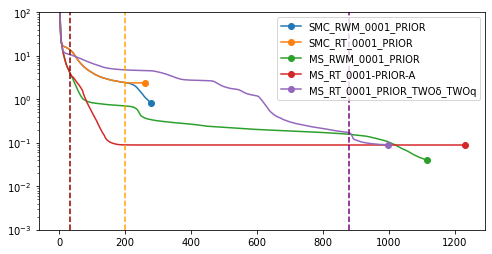

In [69]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(SMC_RWM_0001_PRIOR.εs, label='SMC_RWM_0001_PRIOR', markevery=[-1], marker='o')
ax.plot(SMC_RT_0001_PRIOR.εs, label='SMC_RT_0001_PRIOR', markevery=[-1], marker='o')
ax.plot(MS_RWM_0001_PRIOR.εs, label='MS_RWM_0001_PRIOR', markevery=[-1], marker='o')
ax.plot(MS_RT_0001_PRIOR.εs, label='MS_RT_0001-PRIOR-A', markevery=[-1], marker='o')
ax.plot(MS_RT_0001_PRIOR_TWOδ_TWOq.εs, label='MS_RT_0001_PRIOR_TWOδ_TWOq', markevery=[-1], marker='o')
ax.axvline(SMC_RT_0001_PRIOR.n_switch, color='orange', ls='--')
ax.axvline(MS_RT_0001_PRIOR.n_switch, color='darkred', ls='--')
ax.axvline(MS_RT_0001_PRIOR_TWOδ_TWOq.n_switch, color='purple', ls='--')
ax.set_yscale('log')
ax.set_ylim([0.001, 100])
ax.legend()
plt.show()

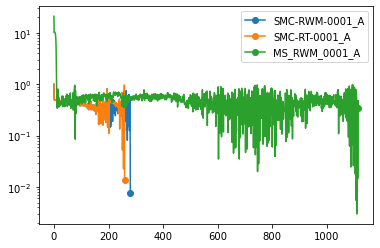

In [43]:
fig, ax = plt.subplots()
ax.plot(np.array(SMC_RWM_0001_PRIOR.ESS)/N, label='SMC-RWM-0001_A', markevery=[-1], marker='o')
ax.plot(np.array(SMC_RT_0001_PRIOR.ESS)/N, label='SMC-RT-0001_A', markevery=[-1], marker='o')
ax.plot(np.array(MS_RWM_0001_PRIOR.ESS)/N, label='MS_RWM_0001_A', markevery=[-1], marker='o')
ax.legend()
ax.set_yscale('log')
plt.show()

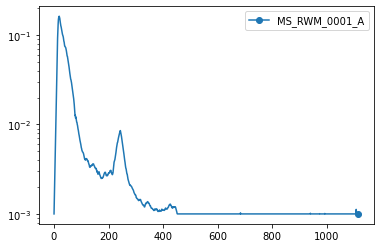

In [49]:
fig, ax = plt.subplots()
ax.plot(MS_RWM_0001_PRIOR.δs, label='MS_RWM_0001_A', markevery=[-1], marker='o')
ax.legend()
ax.set_yscale('log')
plt.show()

# FIXED STEP SIZE

### SMC-RWM

In [17]:
SMC_RWM_01 = SMCAdaptive(generate_settings(
        d=d, 
        N=N,
        B=B,
        δ=0.1,
        δmin=δmin,
        min_pm=min_pm,
        verbose=True,
        εs_fixed=None,
        adaptiveε=True,
        adaptiveδ=False,
        z0_manual=init_particles,
        pm_target=0.23,
        pm_switch=pm_switch,
        prior_seed=seed,
        low_memory=True,
        integrator='rwm',
        εprop_switch=0.01,
        ε0_manual=ε0_manual,
        quantile_value=quantile_value,
        initialization='manual',
        switch_strategy='pm',
        kernel='uniform',
        use_autograd=False,
        stopping_criterion={'εmin', 'pm'}))
_ = SMC_RWM_01.sample()

Stochastic Kernel: RWM.
Stopping criterion:  εmin, pm.
Iteration:  1
	Particles resampled.
	Epsilon: 0.0000000268051501
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.0000000000000000
	Step-size kept fixed at: 0.1000000000000000


In [18]:
SMC_RWM_001 = SMCAdaptive(generate_settings(
        d=d, 
        N=N,
        B=B,
        δ=0.01,
        δmin=δmin,
        min_pm=min_pm,
        verbose=True,
        εs_fixed=None,
        adaptiveε=True,
        adaptiveδ=False,
        z0_manual=init_particles,
        pm_target=0.23,
        pm_switch=pm_switch,
        prior_seed=seed,
        low_memory=True,
        integrator='rwm',
        εprop_switch=0.01,
        ε0_manual=ε0_manual,
        quantile_value=quantile_value,
        initialization='manual',
        switch_strategy='pm',
        kernel='uniform',
        use_autograd=False,
        stopping_criterion={'εmin', 'pm'}))
_ = SMC_RWM_001.sample()

Stochastic Kernel: RWM.
Stopping criterion:  εmin, pm.
Iteration:  1
	Particles resampled.
	Epsilon: 0.0000000265153272
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.0000000000000000
	Step-size kept fixed at: 0.0100000000000000


In [19]:
SMC_RWM_0001 = SMCAdaptive(generate_settings(
        d=d, 
        N=2000,
        B=20,
        δ=0.001,
        δmin=1e-3,
        min_pm=1e-4,
        verbose=True,
        εs_fixed=None,
        adaptiveε=True,
        adaptiveδ=False,
        z0_manual=init_particles,
        pm_target=0.23,
        pm_switch=0.1,
        prior_seed=seed,
        low_memory=True,
        integrator='rwm',
        εprop_switch=0.01,
        ε0_manual=ε0_manual,
        quantile_value=0.9,
        initialization='manual',
        switch_strategy='pm',
        kernel='uniform',
        use_autograd=False,
        stopping_criterion={'εmin', 'pm'}))
_ = SMC_RWM_0001.sample()

Stochastic Kernel: RWM.
Stopping criterion:  εmin, pm.
Iteration:  1
	Particles resampled.
	Epsilon: 16.5631044179340634
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.4900000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  2
	Particles resampled.
	Epsilon: 14.6134849862661582
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.4015000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  3
	Particles resampled.
	Epsilon: 13.5177601177125730
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.3430000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  4
	Particles resampled.
	Epsilon: 12.8114533557872754
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.2610000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  5
	Particles resampled.
	Epsilon: 12.1586389216278299
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.2430000000000000
	Step

	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.0080000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  43
	Particles resampled.
	Epsilon: 5.1420304408806210
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.0020000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  44
	Particles resampled.
	Epsilon: 4.8165419431005638
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.0034999999999999
	Step-size kept fixed at: 0.0010000000000000
Iteration:  45
	Particles resampled.
	Epsilon: 4.7223928102111321
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.0020000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  46
	Particles resampled.
	Epsilon: 4.2120455575109226
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.0014999999999999
	Step-size kept fixed at: 0.0010000000000000
Iteration:  47
	Particles resampled.
	Epsilon: 3.8815285214503157
	Weights comput

### SMC-RT

In [20]:
SMC_RT_01 = SMCAdaptive(generate_settings(
        d=d, 
        N=N,
        B=B,
        δ=0.1,
        δmin=1e-3,
        min_pm=1e-4,
        verbose=True,
        εs_fixed=None,
        adaptiveε=True,
        adaptiveδ=False,
        z0_manual=init_particles,
        pm_target=0.23,
        pm_switch=0.01,
        prior_seed=seed,
        low_memory=True,
        integrator='rwm_then_thug',
        εprop_switch=0.01,
        ε0_manual=ε0_manual,
        quantile_value=0.3,
        initialization='manual',
        switch_strategy='pm',
        kernel='uniform',
        use_autograd=False,
        stopping_criterion={'εmin', 'pm'}))
_ = SMC_RT_01.sample()

Stochastic Kernel: RWM.
Stopping criterion:  εmin, pm.
Iteration:  1
	Particles resampled.
	Epsilon: 0.0000000044084009
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.0000000000000000
	Step-size kept fixed at: 0.1000000000000000


####################################
### SWITCHING TO THUG KERNEL ###
####################################




In [18]:
SMC_RT_001 = SMCAdaptive(generate_settings(
        d=d, 
        N=N,
        B=B,
        δ=0.01,
        δmin=δmin,
        min_pm=min_pm,
        verbose=True,
        εs_fixed=None,
        adaptiveε=True,
        adaptiveδ=False,
        z0_manual=init_particles,
        pm_target=0.23,
        pm_switch=pm_switch,
        prior_seed=seed,
        low_memory=True,
        integrator='rwm_then_thug',
        εprop_switch=0.01,
        ε0_manual=ε0_manual,
        quantile_value=quantile_value,
        initialization='manual',
        switch_strategy='pm',
        kernel='uniform',
        use_autograd=False,
        stopping_criterion={'εmin', 'pm'}))
_ = SMC_RT_001.sample()

Stochastic Kernel: RWM.
Stopping criterion:  εmin, pm.
Iteration:  1
	Particles resampled.
	Epsilon: 14.6090738258715049
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.1065000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  2
	Particles resampled.
	Epsilon: 10.2168393978358232
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.0295000000000000
	Step-size kept fixed at: 0.0100000000000000


####################################
### SWITCHING TO THUG KERNEL ###
####################################


Iteration:  3
	Particles resampled.
	Epsilon: 0.0000005384791395
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.0000000000000000
	Step-size kept fixed at: 0.0100000000000000


In [16]:
SMC_RT_0001 = SMCAdaptive(generate_settings(
        d=d, 
        N=N,
        B=B,
        δ=0.001,
        δmin=δmin,
        min_pm=min_pm,
        verbose=True,
        εs_fixed=None,
        adaptiveε=True,
        adaptiveδ=False,
        z0_manual=init_particles,
        pm_target=0.23,
        pm_switch=pm_switch,
        prior_seed=seed,
        low_memory=True,
        integrator='rwm_then_thug',
        εprop_switch=0.01,
        ε0_manual=ε0_manual,
        quantile_value=quantile_value,
        initialization='manual',
        switch_strategy='pm',
        kernel='uniform',
        use_autograd=False,
        stopping_criterion={'εmin', 'pm'}))
_ = SMC_RT_0001.sample()

Stochastic Kernel: RWM.
Stopping criterion:  εmin, pm.
Iteration:  1
	Particles resampled.
	Epsilon: 14.6090738258715049
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.4615000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  2
	Particles resampled.
	Epsilon: 7.6290382543749207
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.4505000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  3
	Particles resampled.
	Epsilon: 3.0049087761573530
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.2640000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  4
	Particles resampled.
	Epsilon: 2.3347066465779576
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.2015000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  5
	Particles resampled.
	Epsilon: 1.9272497860079931
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.1445000000000000
	Step-siz

	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.2514999999999999
	Step-size kept fixed at: 0.0010000000000000
Iteration:  43
	Particles resampled.
	Epsilon: 0.4449660554687155
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.2590000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  44
	Particles resampled.
	Epsilon: 0.4440107636670662
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.2420000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  45
	Particles resampled.
	Epsilon: 0.4429939918536000
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.2355000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  46
	Particles resampled.
	Epsilon: 0.4421288807125352
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.2490000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  47
	Particles resampled.
	Epsilon: 0.4411531499697310
	Weights comput

# Adaptive Step Size

In [14]:
SMC_RT_001_ADAPTIVE = SMCAdaptive(generate_settings(
        d=d, 
        N=N,
        B=B,
        δ=0.001,
        δmin=δmin,
        min_pm=min_pm,
        verbose=True,
        εs_fixed=None,
        adaptiveε=True,
        adaptiveδ=True,
        z0_manual=init_particles,
        pm_target=0.23,
        pm_switch=pm_switch,
        prior_seed=seed,
        low_memory=True,
        integrator='rwm_then_thug',
        εprop_switch=0.01,
        ε0_manual=ε0_manual,
        quantile_value=quantile_value,
        initialization='manual',
        switch_strategy='pm',
        kernel='uniform',
        use_autograd=False,
        stopping_criterion={'εmin', 'pm'}))
_ = SMC_RT_001_ADAPTIVE.sample()

Stochastic Kernel: RWM.
Stopping criterion:  εmin, pm.
Iteration:  1
	Particles resampled.
	Epsilon: 14.6090738258715049
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.4615000000000000
	Step-size adapted to: 0.0011227151582559
Iteration:  2
	Particles resampled.
	Epsilon: 7.6290382543749207
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.4455000000000000
	Step-size adapted to: 0.0012504456402765
Iteration:  3
	Particles resampled.
	Epsilon: 3.1730465878133698
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.2200000000000000
	Step-size adapted to: 0.0012442090166272
Iteration:  4
	Particles resampled.
	Epsilon: 2.4880962142821552
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.1490000000000000
	Step-size adapted to: 0.0011948253212348
Iteration:  5
	Particles resampled.
	Epsilon: 2.0271691751336709
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.1025000000000000
	Step-size adapted to

	Mutation step done.
	Approx AP: 0.2350000000000000
	Step-size adapted to: 0.0011419644715237
Iteration:  43
	Particles resampled.
	Epsilon: 0.2013785025562513
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.2395000000000000
	Step-size adapted to: 0.0011474017059721
Iteration:  44
	Particles resampled.
	Epsilon: 0.2012703845387916
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.2330000000000000
	Step-size adapted to: 0.0011491241000036
Iteration:  45
	Particles resampled.
	Epsilon: 0.2012060978615578
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.2060000000000000
	Step-size adapted to: 0.0011354170177815
Iteration:  46
	Particles resampled.
	Epsilon: 0.2011577360707765
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.2095000000000000
	Step-size adapted to: 0.0011238384349589
Iteration:  47
	Particles resampled.
	Epsilon: 0.2010985706370761
	Weights computed and normalised.
	Mutation step done.
	Approx A

	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.1850000000000001
	Step-size adapted to: 0.0010000000000000
Iteration:  86
	Particles resampled.
	Epsilon: 0.1984647197783777
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.1990000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  87
	Particles resampled.
	Epsilon: 0.1983952328046256
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.1970000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  88
	Particles resampled.
	Epsilon: 0.1983403650821685
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.1885000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  89
	Particles resampled.
	Epsilon: 0.1982730295249577
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.2025000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  90
	Particles resampled.
	Epsilon: 0.1982015297713998
	Weights computed and normalis

	Mutation step done.
	Approx AP: 0.1680000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  128
	Particles resampled.
	Epsilon: 0.1965759239047484
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.1765000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  129
	Particles resampled.
	Epsilon: 0.1965472939499196
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.1915000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  130
	Particles resampled.
	Epsilon: 0.1965117123173757
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.2095000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  131
	Particles resampled.
	Epsilon: 0.1964687320927664
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.2080000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  132
	Particles resampled.
	Epsilon: 0.1964273516319894
	Weights computed and normalised.
	Mutation step done.
	App

	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.2070000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  171
	Particles resampled.
	Epsilon: 0.1952513765467144
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.1905000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  172
	Particles resampled.
	Epsilon: 0.1952249540228856
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.1975000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  173
	Particles resampled.
	Epsilon: 0.1952037399339503
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.2000000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  174
	Particles resampled.
	Epsilon: 0.1951825671781128
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.1970000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  175
	Particles resampled.
	Epsilon: 0.1951599022054672
	Weights computed and nor

	Mutation step done.
	Approx AP: 0.1899999999999999
	Step-size adapted to: 0.0010000000000000
Iteration:  213
	Particles resampled.
	Epsilon: 0.1939388773017033
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.1955000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  214
	Particles resampled.
	Epsilon: 0.1939063835181753
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.1860000000000001
	Step-size adapted to: 0.0010000000000000
Iteration:  215
	Particles resampled.
	Epsilon: 0.1938794509232005
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.1935000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  216
	Particles resampled.
	Epsilon: 0.1938528573281807
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.1860000000000001
	Step-size adapted to: 0.0010000000000000
Iteration:  217
	Particles resampled.
	Epsilon: 0.1938264512916664
	Weights computed and normalised.
	Mutation step done.
	App

	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.1919999999999999
	Step-size adapted to: 0.0010000000000000
Iteration:  256
	Particles resampled.
	Epsilon: 0.1922185722568736
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.2080000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  257
	Particles resampled.
	Epsilon: 0.1921811253586592
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.1870000000000001
	Step-size adapted to: 0.0010000000000000
Iteration:  258
	Particles resampled.
	Epsilon: 0.1921358217717516
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.2065000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  259
	Particles resampled.
	Epsilon: 0.1920935356032839
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.1835000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  260
	Particles resampled.
	Epsilon: 0.1920511583281927
	Weights computed and nor

	Mutation step done.
	Approx AP: 0.1985000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  298
	Particles resampled.
	Epsilon: 0.1907531260819969
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.2070000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  299
	Particles resampled.
	Epsilon: 0.1907193998635771
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.1875000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  300
	Particles resampled.
	Epsilon: 0.1906822648130365
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.1915000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  301
	Particles resampled.
	Epsilon: 0.1906476224298889
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.1975000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  302
	Particles resampled.
	Epsilon: 0.1906167687934940
	Weights computed and normalised.
	Mutation step done.
	App

	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.1975000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  341
	Particles resampled.
	Epsilon: 0.1896684631864227
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.1990000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  342
	Particles resampled.
	Epsilon: 0.1896437812379648
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.2075000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  343
	Particles resampled.
	Epsilon: 0.1896151222493141
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.2115000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  344
	Particles resampled.
	Epsilon: 0.1895910659419083
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.2160000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  345
	Particles resampled.
	Epsilon: 0.1895692755168352
	Weights computed and nor

	Mutation step done.
	Approx AP: 0.2085000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  383
	Particles resampled.
	Epsilon: 0.1887598583134684
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.2015000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  384
	Particles resampled.
	Epsilon: 0.1887437991424702
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.1950000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  385
	Particles resampled.
	Epsilon: 0.1887292309049590
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.1975000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  386
	Particles resampled.
	Epsilon: 0.1887149203026530
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.1975000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  387
	Particles resampled.
	Epsilon: 0.1886994403108468
	Weights computed and normalised.
	Mutation step done.
	App

	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.2005000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  426
	Particles resampled.
	Epsilon: 0.1880093942487321
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.1925000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  427
	Particles resampled.
	Epsilon: 0.1879830525117307
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.2045000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  428
	Particles resampled.
	Epsilon: 0.1879562313909660
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.2110000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  429
	Particles resampled.
	Epsilon: 0.1879295309313404
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.2060000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  430
	Particles resampled.
	Epsilon: 0.1879030679151980
	Weights computed and nor

	Mutation step done.
	Approx AP: 0.1945000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  468
	Particles resampled.
	Epsilon: 0.1868321836278077
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.1990000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  469
	Particles resampled.
	Epsilon: 0.1867929448672021
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.1840000000000001
	Step-size adapted to: 0.0010000000000000
Iteration:  470
	Particles resampled.
	Epsilon: 0.1867553633279427
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.1940000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  471
	Particles resampled.
	Epsilon: 0.1867203204972011
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.2065000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  472
	Particles resampled.
	Epsilon: 0.1866850655384181
	Weights computed and normalised.
	Mutation step done.
	App

	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.1935000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  511
	Particles resampled.
	Epsilon: 0.1854218302848422
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.2045000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  512
	Particles resampled.
	Epsilon: 0.1853954869736099
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.1860000000000001
	Step-size adapted to: 0.0010000000000000
Iteration:  513
	Particles resampled.
	Epsilon: 0.1853602890379628
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.2025000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  514
	Particles resampled.
	Epsilon: 0.1853248335909889
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.2025000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  515
	Particles resampled.
	Epsilon: 0.1852842040770269
	Weights computed and nor

	Mutation step done.
	Approx AP: 0.1909999999999999
	Step-size adapted to: 0.0010000000000000
Iteration:  553
	Particles resampled.
	Epsilon: 0.1840851362766104
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.2025000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  554
	Particles resampled.
	Epsilon: 0.1840462558348827
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.2015000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  555
	Particles resampled.
	Epsilon: 0.1840078826675856
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.2030000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  556
	Particles resampled.
	Epsilon: 0.1839732443800479
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.1980000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  557
	Particles resampled.
	Epsilon: 0.1839412170661577
	Weights computed and normalised.
	Mutation step done.
	App

	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.2115000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  596
	Particles resampled.
	Epsilon: 0.1828991186214226
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.1835000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  597
	Particles resampled.
	Epsilon: 0.1828746090842993
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.2015000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  598
	Particles resampled.
	Epsilon: 0.1828500374911736
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.1925000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  599
	Particles resampled.
	Epsilon: 0.1828275561747598
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.1945000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  600
	Particles resampled.
	Epsilon: 0.1828039881023221
	Weights computed and nor

	Mutation step done.
	Approx AP: 0.1945000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  638
	Particles resampled.
	Epsilon: 0.1814043587698279
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.2130000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  639
	Particles resampled.
	Epsilon: 0.1813332352092598
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.1899999999999999
	Step-size adapted to: 0.0010000000000000
Iteration:  640
	Particles resampled.
	Epsilon: 0.1812732530590655
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.1785000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  641
	Particles resampled.
	Epsilon: 0.1812152432599478
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.1840000000000001
	Step-size adapted to: 0.0010000000000000
Iteration:  642
	Particles resampled.
	Epsilon: 0.1811591282413390
	Weights computed and normalised.
	Mutation step done.
	App

	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.1965000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  681
	Particles resampled.
	Epsilon: 0.1790876599418159
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.1865000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  682
	Particles resampled.
	Epsilon: 0.1790364144887125
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.1840000000000001
	Step-size adapted to: 0.0010000000000000
Iteration:  683
	Particles resampled.
	Epsilon: 0.1789886442225722
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.1870000000000001
	Step-size adapted to: 0.0010000000000000
Iteration:  684
	Particles resampled.
	Epsilon: 0.1789353259486711
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.2080000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  685
	Particles resampled.
	Epsilon: 0.1788736735180843
	Weights computed and nor

	Mutation step done.
	Approx AP: 0.1845000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  723
	Particles resampled.
	Epsilon: 0.1763820164990434
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.1929999999999999
	Step-size adapted to: 0.0010000000000000
Iteration:  724
	Particles resampled.
	Epsilon: 0.1762996845130985
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.1975000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  725
	Particles resampled.
	Epsilon: 0.1762072130298198
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.2000000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  726
	Particles resampled.
	Epsilon: 0.1761237780146598
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.1960000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  727
	Particles resampled.
	Epsilon: 0.1760452536085175
	Weights computed and normalised.
	Mutation step done.
	App

	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.1905000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  766
	Particles resampled.
	Epsilon: 0.1722993664253221
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.1915000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  767
	Particles resampled.
	Epsilon: 0.1722182204949363
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.1740000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  768
	Particles resampled.
	Epsilon: 0.1721433460338153
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.1795000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  769
	Particles resampled.
	Epsilon: 0.1720519493370892
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.1965000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  770
	Particles resampled.
	Epsilon: 0.1719436657151539
	Weights computed and nor

	Mutation step done.
	Approx AP: 0.1855000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  808
	Particles resampled.
	Epsilon: 0.1641477772266435
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.1975000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  809
	Particles resampled.
	Epsilon: 0.1635554954609209
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.2130000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  810
	Particles resampled.
	Epsilon: 0.1628995905747513
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.2035000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  811
	Particles resampled.
	Epsilon: 0.1622048083840169
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.1975000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  812
	Particles resampled.
	Epsilon: 0.1615683508959533
	Weights computed and normalised.
	Mutation step done.
	App

	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.1955000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  851
	Particles resampled.
	Epsilon: 0.1283040243300747
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.1770000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  852
	Particles resampled.
	Epsilon: 0.1274151505493363
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.1860000000000001
	Step-size adapted to: 0.0010000000000000
Iteration:  853
	Particles resampled.
	Epsilon: 0.1264953710562022
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.1840000000000001
	Step-size adapted to: 0.0010000000000000
Iteration:  854
	Particles resampled.
	Epsilon: 0.1256003156326744
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.1860000000000001
	Step-size adapted to: 0.0010000000000000
Iteration:  855
	Particles resampled.
	Epsilon: 0.1247004582617754
	Weights computed and nor

	Mutation step done.
	Approx AP: 0.1905000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  893
	Particles resampled.
	Epsilon: 0.0868057727709854
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.1830000000000001
	Step-size adapted to: 0.0010000000000000
Iteration:  894
	Particles resampled.
	Epsilon: 0.0857775223657593
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.1850000000000001
	Step-size adapted to: 0.0010000000000000
Iteration:  895
	Particles resampled.
	Epsilon: 0.0847616755671117
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.1845000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  896
	Particles resampled.
	Epsilon: 0.0837843971650387
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.1845000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  897
	Particles resampled.
	Epsilon: 0.0828421618749867
	Weights computed and normalised.
	Mutation step done.
	App

	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.1715000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  936
	Particles resampled.
	Epsilon: 0.0534949351358853
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.1705000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  937
	Particles resampled.
	Epsilon: 0.0530010979443994
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.1665000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  938
	Particles resampled.
	Epsilon: 0.0525937986623980
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.1660000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  939
	Particles resampled.
	Epsilon: 0.0521605941204742
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.1510000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  940
	Particles resampled.
	Epsilon: 0.0517714970918179
	Weights computed and nor

	Mutation step done.
	Approx AP: 0.0639999999999999
	Step-size adapted to: 0.0010000000000000
Iteration:  978
	Particles resampled.
	Epsilon: 0.0464182357691433
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.0605000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  979
	Particles resampled.
	Epsilon: 0.0463847902364480
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.0410000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  980
	Particles resampled.
	Epsilon: 0.0463527590879389
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.0495000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  981
	Particles resampled.
	Epsilon: 0.0463144287203152
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.0575000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  982
	Particles resampled.
	Epsilon: 0.0462789783055724
	Weights computed and normalised.
	Mutation step done.
	App

	Mutation step done.
	Approx AP: 0.0275000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  1020
	Particles resampled.
	Epsilon: 0.0453502106484428
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.0190000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  1021
	Particles resampled.
	Epsilon: 0.0453334758569084
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.0375000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  1022
	Particles resampled.
	Epsilon: 0.0453214758718245
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.0195000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  1023
	Particles resampled.
	Epsilon: 0.0453084570241887
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.0315000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  1024
	Particles resampled.
	Epsilon: 0.0452972635146958
	Weights computed and normalised.
	Mutation step done.

### MS RWM

In [12]:
MS_RWM_001_ADAPTIVE = MSAdaptive(generate_settings(
        d=d, 
        N=N,
        B=B,
        δ=0.001,
        δmin=δmin,
        min_pm=min_pm,
        verbose=True,
        εs_fixed=None,
        adaptiveε=True,
        adaptiveδ=True,
        z0_manual=init_particles,
        pm_target=0.23,
        pm_switch=pm_switch,
        prior_seed=seed,
        low_memory=True,
        integrator='rwm',
        εprop_switch=0.01,
        ε0_manual=ε0_manual,
        quantile_value=quantile_value,
        initialization='manual',
        switch_strategy='pm',
        kernel='uniform',
        use_autograd=False,
        stopping_criterion={'εmin', 'pm'},
        resampling_seed=1234))
_ = MS_RWM_001_ADAPTIVE.sample()

Integrator: RWM.
Stopping criterion:  εmin, pm.
Iteration:  1
	Trajectories constructed.
	Epsilon: 14.5399972504226973
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9440000000000000
	Step-size adapted to: 0.0014290358698539
Iteration:  2
	Trajectories constructed.
	Epsilon: 7.1486353603374466
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9495000000000000
	Step-size adapted to: 0.0020477671409401
Iteration:  3
	Trajectories constructed.
	Epsilon: 1.9385990841414951
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8995000000000000
	Step-size adapted to: 0.0028619408112058
Iteration:  4
	Trajectories constructed.
	Epsilon: 1.3737709706537147
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8510000000000000
	Step-size adapted to: 0.0039039934859829
Iteration:  5
	Trajectories constructed.
	Epsilon: 1.051984

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1640000000000000
	Step-size adapted to: 0.0024479476998953
Iteration:  39
	Trajectories constructed.
	Epsilon: 0.0560010936594076
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1450000000000000
	Step-size adapted to: 0.0023460897356736
Iteration:  40
	Trajectories constructed.
	Epsilon: 0.0529305428269204
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0815000000000000
	Step-size adapted to: 0.0021782025100296
Iteration:  41
	Trajectories constructed.
	Epsilon: 0.0503094898656729
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1080000000000000
	Step-size adapted to: 0.0020493035423743
Iteration:  42
	Trajectories constructed.
	Epsilon: 0.0482724384227198
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1305000000

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0005000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  76
	Trajectories constructed.
	Epsilon: 0.0161138895173824
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0050000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  77
	Trajectories constructed.
	Epsilon: 0.0159851434557981
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1170000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  78
	Trajectories constructed.
	Epsilon: 0.0156620272348467
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0015000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  79
	Trajectories constructed.
	Epsilon: 0.0153024738894668
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0010000000

### MS-RT 

In [7]:
MS_RT_001_ADAPTIVE = MSAdaptive(generate_settings(
        d=d, 
        N=N,
        B=B,
        δ=0.001,
        δmin=δmin,
        min_pm=min_pm,
        verbose=True,
        εs_fixed=None,
        adaptiveε=True,
        adaptiveδ=True,
        z0_manual=init_particles,
        pm_target=[0.23, 0.23],
        pm_switch=pm_switch,
        prior_seed=seed,
        low_memory=True,
        integrator='rwm_then_thug',
        εprop_switch=0.01,
        ε0_manual=ε0_manual,
        quantile_value=quantile_value,
        initialization='manual',
        switch_strategy='pm',
        kernel='uniform',
        use_autograd=False,
        stopping_criterion={'εmin', 'pm'},
        resampling_seed=1234))
_ = MS_RT_001_ADAPTIVE.sample()

Integrator: RWM.
Stopping criterion:  εmin, pm.
Iteration:  1
	Trajectories constructed.
	Epsilon: 14.5399972504226973
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9440000000000000
	Step-size adapted to: 0.0014290358698539
Iteration:  2
	Trajectories constructed.
	Epsilon: 7.1486353603374466
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9540000000000000
	Step-size adapted to: 0.0020523798043075
Iteration:  3
	Trajectories constructed.
	Epsilon: 1.9102718614272871
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8905000000000000
	Step-size adapted to: 0.0028555086832381
Iteration:  4
	Trajectories constructed.
	Epsilon: 1.3408708975652828
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8300000000000000
	Step-size adapted to: 0.0038545335461787
Iteration:  5
	Trajectories constructed.
	Epsilon: 1.035336

	Trajectories constructed.
	Epsilon: 0.0569160496590934
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1440000000000000
	Step-size adapted to: 0.1606535205930618
Iteration:  38
	Trajectories constructed.
	Epsilon: 0.0547622101495369
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0745000000000000
	Step-size adapted to: 0.1486359458895483
Iteration:  39
	Trajectories constructed.
	Epsilon: 0.0528210974325665
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1890000000000000
	Step-size adapted to: 0.1456199287967063
Iteration:  40
	Trajectories constructed.
	Epsilon: 0.0509107204925064
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2700000000000000
	Step-size adapted to: 0.1485616464930005
Iteration:  41
	Trajectories constructed.
	Epsilon: 0.0485163945692184
	Weights computed and normalized.
	Particles Res

	Trajectories constructed.
	Epsilon: 0.0186734873769504
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1405000000000000
	Step-size adapted to: 0.0344496900389088
Iteration:  75
	Trajectories constructed.
	Epsilon: 0.0179869292343040
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1550000000000000
	Step-size adapted to: 0.0331817491376896
Iteration:  76
	Trajectories constructed.
	Epsilon: 0.0173324564729727
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1735000000000000
	Step-size adapted to: 0.0322574814731081
Iteration:  77
	Trajectories constructed.
	Epsilon: 0.0168089859313027
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1210000000000000
	Step-size adapted to: 0.0305464965552834
Iteration:  78
	Trajectories constructed.
	Epsilon: 0.0164106369887585
	Weights computed and normalized.
	Particles Res

	Trajectories constructed.
	Epsilon: 0.0128936295531301
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1040000000000000
	Step-size adapted to: 0.0065600616448983
Iteration:  112
	Trajectories constructed.
	Epsilon: 0.0128819628895247
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0780000000000000
	Step-size adapted to: 0.0060799714485203
Iteration:  113
	Trajectories constructed.
	Epsilon: 0.0128716843766008
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1030000000000000
	Step-size adapted to: 0.0057058958505233
Iteration:  114
	Trajectories constructed.
	Epsilon: 0.0128600404168194
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1430000000000000
	Step-size adapted to: 0.0054630104375436
Iteration:  115
	Trajectories constructed.
	Epsilon: 0.0128488075676792
	Weights computed and normalized.
	Particles

	Trajectories constructed.
	Epsilon: 0.0126747660191048
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1300000000000000
	Step-size adapted to: 0.0016319081919060
Iteration:  149
	Trajectories constructed.
	Epsilon: 0.0126735621907164
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1255000000000000
	Step-size adapted to: 0.0015488302986341
Iteration:  150
	Trajectories constructed.
	Epsilon: 0.0126725995710255
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2565000000000000
	Step-size adapted to: 0.0015694888608274
Iteration:  151
	Trajectories constructed.
	Epsilon: 0.0126717480294676
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1100000000000000
	Step-size adapted to: 0.0014780889449828
Iteration:  152
	Trajectories constructed.
	Epsilon: 0.0126709321295567
	Weights computed and normalized.
	Particles

	Trajectories constructed.
	Epsilon: 0.0126608316138075
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1150000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  186
	Trajectories constructed.
	Epsilon: 0.0126604511241681
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0640000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  187
	Trajectories constructed.
	Epsilon: 0.0126602281854471
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1860000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  188
	Trajectories constructed.
	Epsilon: 0.0126600245482554
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0410000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  189
	Trajectories constructed.
	Epsilon: 0.0126598376687719
	Weights computed and normalized.
	Particles

	Trajectories constructed.
	Epsilon: 0.0126540789973048
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0270000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  223
	Trajectories constructed.
	Epsilon: 0.0126539077618756
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0375000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  224
	Trajectories constructed.
	Epsilon: 0.0126537058256991
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0450000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  225
	Trajectories constructed.
	Epsilon: 0.0126535331890463
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0465000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  226
	Trajectories constructed.
	Epsilon: 0.0126533508393624
	Weights computed and normalized.
	Particles

	Trajectories constructed.
	Epsilon: 0.0126454508301894
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0375000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  260
	Trajectories constructed.
	Epsilon: 0.0126452894455339
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0350000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  261
	Trajectories constructed.
	Epsilon: 0.0126451669046427
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0385000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  262
	Trajectories constructed.
	Epsilon: 0.0126450562172209
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0370000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  263
	Trajectories constructed.
	Epsilon: 0.0126449399974040
	Weights computed and normalized.
	Particles

	Trajectories constructed.
	Epsilon: 0.0126386068010773
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0665000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  297
	Trajectories constructed.
	Epsilon: 0.0126384377625295
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1270000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  298
	Trajectories constructed.
	Epsilon: 0.0126382693585297
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0540000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  299
	Trajectories constructed.
	Epsilon: 0.0126380755174839
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1240000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  300
	Trajectories constructed.
	Epsilon: 0.0126379047224741
	Weights computed and normalized.
	Particles

	Trajectories constructed.
	Epsilon: 0.0126310040236541
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1015000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  334
	Trajectories constructed.
	Epsilon: 0.0126307562895535
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0930000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  335
	Trajectories constructed.
	Epsilon: 0.0126304912746768
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0895000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  336
	Trajectories constructed.
	Epsilon: 0.0126301698419362
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0510000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  337
	Trajectories constructed.
	Epsilon: 0.0126299240263609
	Weights computed and normalized.
	Particles

	Trajectories constructed.
	Epsilon: 0.0126240061291200
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0435000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  371
	Trajectories constructed.
	Epsilon: 0.0126237949975786
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0810000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  372
	Trajectories constructed.
	Epsilon: 0.0126236785428747
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0970000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  373
	Trajectories constructed.
	Epsilon: 0.0126235194191715
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0520000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  374
	Trajectories constructed.
	Epsilon: 0.0126233919247402
	Weights computed and normalized.
	Particles

	Trajectories constructed.
	Epsilon: 0.0126171998786125
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0980000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  408
	Trajectories constructed.
	Epsilon: 0.0126169613310843
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1440000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  409
	Trajectories constructed.
	Epsilon: 0.0126166564669505
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0720000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  410
	Trajectories constructed.
	Epsilon: 0.0126163935300647
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0500000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  411
	Trajectories constructed.
	Epsilon: 0.0126161853172101
	Weights computed and normalized.
	Particles

	Trajectories constructed.
	Epsilon: 0.0126106384226322
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0515000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  445
	Trajectories constructed.
	Epsilon: 0.0126104773725212
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0370000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  446
	Trajectories constructed.
	Epsilon: 0.0126103757272043
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0570000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  447
	Trajectories constructed.
	Epsilon: 0.0126102423660996
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0355000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  448
	Trajectories constructed.
	Epsilon: 0.0126101351831587
	Weights computed and normalized.
	Particles

	Trajectories constructed.
	Epsilon: 0.0126039688299828
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0890000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  482
	Trajectories constructed.
	Epsilon: 0.0126038280294211
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0570000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  483
	Trajectories constructed.
	Epsilon: 0.0126036339467199
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0435000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  484
	Trajectories constructed.
	Epsilon: 0.0126034036125050
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0245000000000000
	Step-size adapted to: 0.0010000000000000
Iteration:  485
	Trajectories constructed.
	Epsilon: 0.0126032457099500
	Weights computed and normalized.
	Particles

# Plot

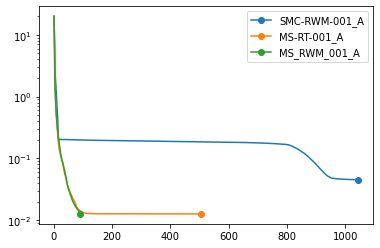

In [15]:
fig, ax = plt.subplots()
# ax.plot(SMC_RWM_01.εs, label='SMC-RWM-01', markevery=[-1], marker='o')
# ax.plot(SMC_RWM_001.εs, label='SMC-RWM-001', markevery=[-1], marker='o')
# ax.plot(SMC_RWM_0001.εs, label='SMC-RWM-0001', markevery=[-1], marker='o')
ax.plot(SMC_RT_001_ADAPTIVE.εs, label='SMC-RWM-001_A', markevery=[-1], marker='o')
ax.plot(MS_RT_001_ADAPTIVE.εs, label='MS-RT-001_A', markevery=[-1], marker='o')
ax.plot(MS_RWM_001_ADAPTIVE.εs, label='MS_RWM_001_A', markevery=[-1], marker='o')
ax.set_yscale('log')
ax.legend()
plt.show()